In [ ]:
# ============================================================================
# Re-Ranking Evaluation Notebook - Step 1: Setup and Imports
# ============================================================================

# %% [markdown]
# # Re-Ranking Evaluation for RAG Systems
# 
# This notebook evaluates the impact of re-ranking on retrieval performance.
# It compares baseline retrieval against two-stage retrieval (retrieve + re-rank).

# %% [markdown]
# ## Step 1.1: Imports

# %%
import os
import json
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from collections import defaultdict

# Environment
from dotenv import load_dotenv

# Progress
from tqdm.auto import tqdm

# Data
from datasets import load_dataset

# Vector stores
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain_voyageai import VoyageAIEmbeddings

# Re-ranking
from sentence_transformers import CrossEncoder
from langchain_voyageai import VoyageAIRerank

print("✓ All imports successful")

# %% [markdown]
# ## Step 1.2: Load Environment Variables

# %%
# Load .env file
load_dotenv()

# Check environment variables
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
OLLAMA_BASE_URL = os.getenv("OLLAMA_BASE_URL", "http://localhost:11434")
VOYAGE_API_KEY = os.getenv("VOYAGE_API_KEY")

if OPENAI_API_KEY:
    print("✓ OpenAI API key loaded")
else:
    print("⚠ OpenAI API key not found (only needed if using OpenAI embeddings)")

if VOYAGE_API_KEY:
    print("✓ VoyageAI API key loaded")
else:
    print("⚠ VoyageAI API key not found (only needed if using VoyageAI embeddings/reranking)")

print(f"✓ Ollama URL: {OLLAMA_BASE_URL}")

# %% [markdown]
# ## Step 1.3: Configuration Variables

# %%
# Paths
VECTOR_DB_BASE_DIR = "../../vector_databases"
OUTPUT_DIR = "../../evaluation_results/reranking"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Dataset
DATASET_NAME = "PatronusAI/financebench"
DATASET_SPLIT = "train"

# Collection settings
COLLECTION_PREFIX = "financebench_docs_chunk_"

print("✓ Configuration set")
print(f"  Vector DB Directory: {VECTOR_DB_BASE_DIR}")
print(f"  Output Directory: {OUTPUT_DIR}")

# %% [markdown]
# ## Step 1.4: Load FinanceBench Dataset

# %%
print("Loading FinanceBench dataset...")
dataset = load_dataset(DATASET_NAME, split=DATASET_SPLIT)
print(f"✓ Loaded {len(dataset)} queries")

# Show sample
print("\nSample query:")
sample = dataset[0]
print(f"  ID: {sample['financebench_id']}")
print(f"  Company: {sample['company']}")
print(f"  Question: {sample['question'][:100]}...")
print(f"  Doc: {sample['doc_name']}")
print(f"  Evidence items: {len(sample['evidence'])}")

# %%
print("\n✓ Step 1 complete!")
print("  Environment variables loaded")
print("  Paths configured")
print(f"  Dataset loaded: {len(dataset)} queries")

✓ All imports successful
✓ OpenAI API key loaded
✓ VoyageAI API key loaded
✓ Ollama URL: http://localhost:11434
✓ Configuration set
  Vector DB Directory: ../../vector_databases
  Output Directory: ../../evaluation_results/reranking
Loading FinanceBench dataset...
✓ Loaded 150 queries

Sample query:
  ID: financebench_id_03029
  Company: 3M
  Question: What is the FY2018 capital expenditure amount (in USD millions) for 3M? Give a response to the quest...
  Doc: 3M_2018_10K
  Evidence items: 1

✓ Step 1 complete!
  Environment variables loaded
  Paths configured
  Dataset loaded: 150 queries


In [ ]:
# ============================================================================
# Step 2: Helper Functions
# ============================================================================

# %% [markdown]
# ## Step 2.1: Metadata Extraction

# %%
def extract_doc_name_from_path(file_path: str) -> str:
    """
    Extract document name from file path.
    
    Example: "../../financebench/documents/3M_2018_10K.pdf" -> "3M_2018_10K"
    """
    filename = os.path.basename(file_path)
    doc_name = filename.replace('.pdf', '')
    return doc_name


def extract_metadata_from_retrieved_doc(doc) -> Dict:
    """
    Extract relevant metadata from retrieved document.
    
    Returns dict with: doc_name, page_number, content
    """
    file_path = doc.metadata.get('file_path', '')
    doc_name = extract_doc_name_from_path(file_path)
    page_num = doc.metadata.get('source', -1)
    
    # Ensure page_num is an integer
    if isinstance(page_num, str):
        page_num = int(page_num)
    
    return {
        'doc_name': doc_name,
        'page_number': page_num,
        'content': doc.page_content
    }

print("✓ Metadata extraction functions defined")

# %% [markdown]
# ## Step 2.2: Vector Store Loading

# %%
def get_embedding_function(provider: str, model: str):
    """Get embedding function for a provider/model."""
    if provider == "ollama":
        return OllamaEmbeddings(model=model, base_url=OLLAMA_BASE_URL)
    elif provider == "openai":
        return OpenAIEmbeddings(model=model, openai_api_key=OPENAI_API_KEY)
    elif provider == "voyage":
        return VoyageAIEmbeddings(model=model, voyage_api_key=VOYAGE_API_KEY)
    else:
        raise ValueError(f"Unknown provider: {provider}")


def load_vectorstore(
    provider: str,
    model: str,
    chunk_size: int,
    base_dir: str = VECTOR_DB_BASE_DIR,
    collection_prefix: str = COLLECTION_PREFIX
) -> Chroma:
    """
    Load a vector store.
    
    Args:
        provider: "ollama", "openai", or "voyage"
        model: Model name
        chunk_size: Chunk size (must match existing collection)
        base_dir: Base directory for vector databases
        collection_prefix: Collection name prefix
        
    Returns:
        Chroma vectorstore instance
    """
    model_id = f"{provider}_{model.replace('/', '_')}"
    db_path = os.path.join(base_dir, model_id)
    collection_name = f"{collection_prefix}{chunk_size}"
    
    emb_fn = get_embedding_function(provider, model)
    
    vectorstore = Chroma(
        collection_name=collection_name,
        embedding_function=emb_fn,
        persist_directory=db_path
    )
    
    return vectorstore

print("✓ Vector store loading functions defined")

# %% [markdown]
# ## Step 2.3: Evidence Matching

# %%
def check_match(
    retrieved_doc: Dict, 
    evidence_list: List[Dict],
    chunk_size: int = 512,
    use_page_tolerance: bool = True
) -> bool:
    """
    Check if retrieved document matches any evidence.
    
    Uses chunk-size-aware page tolerance:
    - chunk_size <= 512: tolerance = 0 (exact match)
    - chunk_size 513-1024: tolerance = 1
    - chunk_size 1025-2048: tolerance = 2
    - chunk_size > 2048: tolerance = 2
    
    Args:
        retrieved_doc: {doc_name, page_number}
        evidence_list: Ground truth evidence
        chunk_size: Chunk size (for page tolerance calculation)
        use_page_tolerance: If True, use chunk-size-aware tolerance
        
    Returns:
        True if match found
    """
    retrieved_doc_name = retrieved_doc['doc_name']
    retrieved_page = retrieved_doc['page_number']
    
    # Calculate page tolerance based on chunk size
    if use_page_tolerance:
        if chunk_size <= 512:
            page_tolerance = 0
        elif chunk_size <= 1024:
            page_tolerance = 1
        elif chunk_size <= 2048:
            page_tolerance = 2
        else:
            page_tolerance = 2
    else:
        page_tolerance = 0  # Exact match only
    
    for evidence in evidence_list:
        evidence_doc_name = evidence['doc_name']
        evidence_page = evidence['evidence_page_num'] + 1  # Convert 0-indexed to 1-indexed
        
        # Check document name match
        if retrieved_doc_name != evidence_doc_name:
            continue
        
        # Check page match with tolerance
        # Only match if retrieved page is BEFORE or AT evidence page
        if retrieved_page <= evidence_page <= retrieved_page + page_tolerance:
            return True
    
    return False


def calculate_mrr_for_query(
    retrieved_docs: List[Dict], 
    evidence_list: List[Dict],
    chunk_size: int = 512,
    use_page_tolerance: bool = True
) -> Tuple[float, int]:
    """
    Calculate MRR for a single query.
    
    Args:
        retrieved_docs: List of {doc_name, page_number}
        evidence_list: Ground truth evidence
        chunk_size: Chunk size (for page tolerance)
        use_page_tolerance: If True, use chunk-size-aware tolerance
        
    Returns:
        Tuple of (mrr_score, rank)
        - mrr_score: 1/rank if found, 0 if not found
        - rank: Position of first match (1-indexed), -1 if not found
    """
    for rank, retrieved_doc in enumerate(retrieved_docs, start=1):
        if check_match(retrieved_doc, evidence_list, chunk_size, use_page_tolerance):
            mrr_score = 1.0 / rank
            return mrr_score, rank
    
    # No match found
    return 0.0, -1

print("✓ Evidence matching functions defined")

# %% [markdown]
# ## Step 2.4: File Management

# %%
def get_reranker_short_name(reranker_model: str) -> str:
    """
    Get short name for reranker model for filename.
    
    Examples:
        'cross-encoder/ms-marco-MiniLM-L-12-v2' -> 'ms-marco-L-12'
        'voyage-rerank-2.5' -> 'voyage-rerank-2.5'
    """
    name_mapping = {
        'cross-encoder/ms-marco-MiniLM-L-6-v2': 'ms-marco-L-6',
        'cross-encoder/ms-marco-MiniLM-L-12-v2': 'ms-marco-L-12',
        'BAAI/bge-reranker-base': 'bge-base',
        'BAAI/bge-reranker-large': 'bge-large',
        'voyage-rerank-2.5': 'voyage-rerank-2.5',
        'voyage-rerank-2.5-lite': 'voyage-rerank-2.5-lite',
    }
    return name_mapping.get(reranker_model, reranker_model.replace('/', '_'))


def get_output_filename(
    provider: str, 
    model: str, 
    chunk_size: int, 
    k: int, 
    mode: str,
    reranker_model: Optional[str] = None,
    k_rerank: Optional[int] = None
) -> str:
    """
    Generate output filename.
    
    Examples:
        Baseline: "voyage_voyage-finance-2_chunk512_k40_global.json"
        Rerank:   "voyage_voyage-finance-2_chunk512_k40_global_rerank_k10-ms-marco-L-12.json"
    
    Args:
        provider: Embedding provider
        model: Embedding model name
        chunk_size: Chunk size
        k: k_retrieve for baseline, or k_retrieve for rerank
        mode: "global" or "singledoc"
        reranker_model: Re-ranker model name (None for baseline)
        k_rerank: Number kept after re-ranking (only for rerank files)
    """
    model_clean = model.replace('/', '_')
    
    if reranker_model:
        # Re-ranking file: show both k_retrieve and k_rerank
        reranker_short = get_reranker_short_name(reranker_model)
        filename = f"{provider}_{model_clean}_chunk{chunk_size}_k{k}_{mode}_rerank_k{k_rerank}-{reranker_short}.json"
    else:
        # Baseline file: only show k_retrieve
        filename = f"{provider}_{model_clean}_chunk{chunk_size}_k{k}_{mode}.json"
    
    return filename


def check_if_results_exist(
    provider: str, 
    model: str, 
    chunk_size: int, 
    k: int, 
    mode: str,
    output_dir: str,
    reranker_model: Optional[str] = None,
    k_rerank: Optional[int] = None
) -> bool:
    """Check if results JSON already exists."""
    filename = get_output_filename(provider, model, chunk_size, k, mode, reranker_model, k_rerank)
    filepath = os.path.join(output_dir, filename)
    return os.path.exists(filepath)


def save_results(
    results: List[Dict], 
    provider: str, 
    model: str, 
    chunk_size: int, 
    k: int, 
    mode: str,
    output_dir: str,
    reranker_model: Optional[str] = None,
    k_rerank: Optional[int] = None
):
    """Save results to JSON file."""
    filename = get_output_filename(provider, model, chunk_size, k, mode, reranker_model, k_rerank)
    filepath = os.path.join(output_dir, filename)
    
    with open(filepath, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✓ Saved: {filename}")

print("✓ File management functions defined")

# %%
print("\n✓ Step 2 complete!")
print("  Metadata extraction: extract_doc_name_from_path, extract_metadata_from_retrieved_doc")
print("  Vector store: get_embedding_function, load_vectorstore")
print("  Evidence matching: check_match, calculate_mrr_for_query")
print("  File management: get_output_filename, check_if_results_exist, save_results")

✓ Metadata extraction functions defined
✓ Vector store loading functions defined
✓ Evidence matching functions defined
✓ File management functions defined

✓ Step 2 complete!
  Metadata extraction: extract_doc_name_from_path, extract_metadata_from_retrieved_doc
  Vector store: get_embedding_function, load_vectorstore
  Evidence matching: check_match, calculate_mrr_for_query
  File management: get_output_filename, check_if_results_exist, save_results


In [16]:
# ============================================================================
# Step 3: Baseline Retrieval Functions
# ============================================================================

# %% [markdown]
# ## Step 3.1: Global Retrieval with Scores

# %%
def retrieve_global_with_scores(
    vectorstore: Chroma,
    query: str,
    k: int
) -> List[Dict]:
    """
    Retrieve documents globally (search all documents) with similarity scores.
    
    Args:
        vectorstore: ChromaDB vectorstore instance
        query: Search query
        k: Number of documents to retrieve
        
    Returns:
        List of {doc_name, page_number, content, rank, score}
    """
    # Use similarity_search_with_score to get scores
    results = vectorstore.similarity_search_with_score(query, k=k)
    
    retrieved = []
    for rank, (doc, score) in enumerate(results, start=1):
        metadata = extract_metadata_from_retrieved_doc(doc)
        metadata['rank'] = rank
        metadata['score'] = float(score)
        retrieved.append(metadata)
    
    return retrieved

print("✓ Global retrieval function defined")

# %% [markdown]
# ## Step 3.2: Single-Document Retrieval with Scores

# %%
def retrieve_single_doc_with_scores(
    vectorstore: Chroma,
    query: str,
    target_doc_name: str,
    k: int
) -> List[Dict]:
    """
    Retrieve documents filtered to single document with scores.
    
    Since ChromaDB doesn't support filtering by document name directly,
    we retrieve more documents (k * 10) and filter them post-retrieval.
    
    Args:
        vectorstore: ChromaDB vectorstore instance
        query: Search query
        target_doc_name: Document name to filter to (e.g., "3M_2018_10K")
        k: Number of documents to return after filtering
        
    Returns:
        List of {doc_name, page_number, content, rank, score}
    """
    # Retrieve more documents than needed to ensure we get enough from target doc
    fetch_k = min(k * 10, 100)  # Fetch up to 10x k, max 100
    
    results = vectorstore.similarity_search_with_score(query, k=fetch_k)
    
    # Filter to only documents from target doc
    filtered = []
    for doc, score in results:
        metadata = extract_metadata_from_retrieved_doc(doc)
        if metadata['doc_name'] == target_doc_name:
            metadata['score'] = float(score)
            filtered.append(metadata)
            if len(filtered) >= k:
                break
    
    # Add rank after filtering
    for rank, doc_meta in enumerate(filtered[:k], start=1):
        doc_meta['rank'] = rank
    
    # Return top k from target document
    return filtered[:k]

print("✓ Single-document retrieval function defined")

# %% [markdown]
# ## Step 3.3: Unified Retrieval Interface

# %%
def retrieve_with_scores(
    vectorstore: Chroma,
    query: str,
    k: int,
    mode: str,
    target_doc_name: Optional[str] = None
) -> List[Dict]:
    """
    Unified interface for retrieval with scores.
    
    Args:
        vectorstore: ChromaDB vectorstore instance
        query: Search query
        k: Number of documents to retrieve
        mode: "global" or "singledoc"
        target_doc_name: Required if mode is "singledoc"
        
    Returns:
        List of {doc_name, page_number, content, rank, score}
    """
    if mode == "global":
        return retrieve_global_with_scores(vectorstore, query, k)
    elif mode == "singledoc":
        if not target_doc_name:
            raise ValueError("target_doc_name required for singledoc mode")
        return retrieve_single_doc_with_scores(vectorstore, query, target_doc_name, k)
    else:
        raise ValueError(f"Unknown mode: {mode}. Must be 'global' or 'singledoc'")

print("✓ Unified retrieval interface defined")

# %% [markdown]
# ## Step 3.4: Test Retrieval (Optional)

# %%
# Uncomment to test retrieval functions

# Test with a sample configuration
test_provider = "voyage"
test_model = "voyage-3-large"
test_chunk_size = 512

print("\\nTesting retrieval functions...")
print(f"Loading vectorstore: {test_provider}/{test_model}, chunk={test_chunk_size}")

try:
    test_vs = load_vectorstore(test_provider, test_model, test_chunk_size)
    test_query = "What was the capital expenditure in 2018?"
    
    print(f"\\nTest query: {test_query}")
    
    # Test global retrieval
    print("\\n--- Global Retrieval (k=5) ---")
    results_global = retrieve_global_with_scores(test_vs, test_query, k=5)
    for i, doc in enumerate(results_global, 1):
        print(f"{i}. {doc['doc_name']}, page {doc['page_number']}, score: {doc['score']:.4f}")
    
    # Test single-doc retrieval
    print("\\n--- Single-Doc Retrieval (k=5, doc='3M_2018_10K') ---")
    results_single = retrieve_single_doc_with_scores(test_vs, test_query, "3M_2018_10K", k=5)
    for i, doc in enumerate(results_single, 1):
        print(f"{i}. {doc['doc_name']}, page {doc['page_number']}, score: {doc['score']:.4f}")
    
    print("\\n✓ Retrieval functions working correctly!")
    
except Exception as e:
    print(f"✗ Test failed: {e}")


# %%
print("\n✓ Step 3 complete!")
print("  Global retrieval: retrieve_global_with_scores")
print("  Single-doc retrieval: retrieve_single_doc_with_scores")
print("  Unified interface: retrieve_with_scores")
print("\nThese functions return documents with similarity scores that will be")
print("preserved as 'initial_score' when we apply re-ranking in Step 4.")

✓ Global retrieval function defined
✓ Single-document retrieval function defined
✓ Unified retrieval interface defined
\nTesting retrieval functions...
Loading vectorstore: voyage/voyage-3-large, chunk=512
\nTest query: What was the capital expenditure in 2018?
\n--- Global Retrieval (k=5) ---
1. BOEING_2018_10K, page 39, score: 0.7928
2. CVSHEALTH_2018_10K, page 280, score: 0.8283
3. MGMRESORTS_2018_10K, page 46, score: 0.8411
4. ACTIVISIONBLIZZARD_2019_10K, page 52, score: 0.8509
5. CORNING_2020_10K, page 126, score: 0.8647
\n--- Single-Doc Retrieval (k=5, doc='3M_2018_10K') ---
1. 3M_2018_10K, page 39, score: 0.9703
2. 3M_2018_10K, page 47, score: 0.9908
3. 3M_2018_10K, page 109, score: 1.0054
4. 3M_2018_10K, page 81, score: 1.0193
\n✓ Retrieval functions working correctly!

✓ Step 3 complete!
  Global retrieval: retrieve_global_with_scores
  Single-doc retrieval: retrieve_single_doc_with_scores
  Unified interface: retrieve_with_scores

These functions return documents with similar

In [ ]:
# ============================================================================
# Step 4: Re-Ranking Functions
# ============================================================================

# %% [markdown]
# ## Step 4.1: Cross-Encoder Re-Ranking (Hugging Face Models)

# %%
def rerank_with_cross_encoder(
    query: str,
    retrieved_docs: List[Dict],
    reranker_model: str,
    top_k: int
) -> List[Dict]:
    """
    Re-rank documents using a cross-encoder model from Hugging Face.
    
    Cross-encoders process query and document together, providing more
    accurate relevance scores than bi-encoders (embeddings).
    
    Args:
        query: Search query
        retrieved_docs: List from baseline retrieval (with 'content', 'rank', 'score')
        reranker_model: Hugging Face model name (e.g., 'cross-encoder/ms-marco-MiniLM-L-12-v2')
        top_k: Number of documents to return after re-ranking
        
    Returns:
        Re-ranked list with {doc_name, page_number, rank, initial_rank, initial_score, rerank_score}
    """
    from sentence_transformers import CrossEncoder
    
    # Initialize cross-encoder
    cross_encoder = CrossEncoder(reranker_model)
    
    # Prepare query-document pairs for cross-encoder
    pairs = [[query, doc.get('content', '')] for doc in retrieved_docs]
    
    # Get cross-encoder relevance scores
    rerank_scores = cross_encoder.predict(pairs)
    
    # Preserve initial ranking information and add rerank scores
    for doc, rerank_score in zip(retrieved_docs, rerank_scores):
        doc['initial_rank'] = doc['rank']
        doc['initial_score'] = doc['score']
        doc['rerank_score'] = float(rerank_score)
        # Remove temporary fields
        del doc['rank']
        del doc['score']
        # Remove content to save space in JSON (optional)
        if 'content' in doc:
            del doc['content']
    
    # Sort by rerank score (descending - higher is more relevant)
    reranked = sorted(retrieved_docs, key=lambda x: x['rerank_score'], reverse=True)
    
    # Assign new ranks
    for rank, doc in enumerate(reranked[:top_k], start=1):
        doc['rank'] = rank
    
    return reranked[:top_k]

print("✓ Cross-encoder re-ranking function defined")

# %% [markdown]
# ## Step 4.2: Voyage AI Re-Ranking (API-based)

# %%
def rerank_with_voyage(
    query: str,
    retrieved_docs: List[Dict],
    reranker_model: str,
    top_k: int
) -> List[Dict]:
    """
    Re-rank documents using Voyage AI reranker API.
    
    Voyage provides specialized rerankers optimized for different domains.
    
    Args:
        query: Search query
        retrieved_docs: List from baseline retrieval (with 'content', 'rank', 'score')
        reranker_model: Voyage model name (e.g., 'voyage-rerank-2', 'voyage-rerank-2-lite')
        top_k: Number of documents to return after re-ranking
        
    Returns:
        Re-ranked list with {doc_name, page_number, rank, initial_rank, initial_score, rerank_score}
    """
    from langchain.schema import Document
    from langchain_voyageai import VoyageAIRerank
    
    # Convert to LangChain documents (required by VoyageAIRerank)
    lc_docs = [
        Document(
            page_content=doc['content'],
            metadata={
                'doc_name': doc['doc_name'], 
                'page_number': doc['page_number'],
                'initial_rank': doc['rank'],
                'initial_score': doc['score']
            }
        )
        for doc in retrieved_docs
    ]
    
    # Initialize Voyage reranker
    # Extract model name (e.g., "rerank-2" from "voyage-rerank-2")
    model_name = reranker_model.replace('voyage-', '')
    
    reranker = VoyageAIRerank(
        model=model_name,
        voyage_api_key=VOYAGE_API_KEY,
        top_k=top_k
    )
    
    # Rerank documents
    reranked_docs = reranker.compress_documents(lc_docs, query)
    
    # Convert back to our format
    results = []
    for rank, doc in enumerate(reranked_docs, start=1):
        result = {
            'doc_name': doc.metadata['doc_name'],
            'page_number': doc.metadata['page_number'],
            'rank': rank,
            'initial_rank': doc.metadata['initial_rank'],
            'initial_score': doc.metadata['initial_score'],
            'rerank_score': doc.metadata.get('relevance_score', 0.0)
        }
        results.append(result)
    
    return results

print("✓ Voyage AI re-ranking function defined")

# %% [markdown]
# ## Step 4.3: Unified Re-Ranking Interface

# %%
def rerank_documents(
    query: str,
    retrieved_docs: List[Dict],
    reranker_model: str,
    top_k: int
) -> List[Dict]:
    """
    Unified interface for re-ranking documents.
    
    Automatically selects the appropriate re-ranker based on model name:
    - Voyage models (starting with 'voyage-'): Use Voyage API
    - Others: Use Hugging Face cross-encoders
    
    Args:
        query: Search query
        retrieved_docs: List from baseline retrieval
        reranker_model: Model name (e.g., 'voyage-rerank-2' or 'cross-encoder/ms-marco-MiniLM-L-12-v2')
        top_k: Number of documents to return after re-ranking
        
    Returns:
        Re-ranked list with scores and ranking information
    """
    if reranker_model.startswith('voyage-'):
        return rerank_with_voyage(query, retrieved_docs, reranker_model, top_k)
    else:
        return rerank_with_cross_encoder(query, retrieved_docs, reranker_model, top_k)

print("✓ Unified re-ranking interface defined")

# %% [markdown]
# ## Step 4.4: Test Re-Ranking (Optional)

# %%
# Uncomment to test re-ranking functions

# Test with a sample configuration
test_provider = "voyage"
test_model = "voyage-finance-2"
test_chunk_size = 512
test_reranker = "cross-encoder/ms-marco-MiniLM-L-12-v2"  # or "voyage-rerank-2"

print("\\nTesting re-ranking functions...")
print(f"Embedding: {test_provider}/{test_model}, chunk={test_chunk_size}")
print(f"Re-ranker: {test_reranker}")

try:
    # Load vectorstore and retrieve
    test_vs = load_vectorstore(test_provider, test_model, test_chunk_size)
    test_query = "What was the capital expenditure in 2018?"
    
    print(f"\\nTest query: {test_query}")
    print("\\n--- Step 1: Baseline Retrieval (k=20) ---")
    
    baseline_results = retrieve_global_with_scores(test_vs, test_query, k=20)
    
    print("Top 5 from baseline:")
    for i, doc in enumerate(baseline_results[:5], 1):
        print(f"{i}. {doc['doc_name']}, page {doc['page_number']}, score: {doc['score']:.4f}")
    
    print("\\n--- Step 2: Re-Ranking (top_k=10) ---")
    
    reranked_results = rerank_documents(
        query=test_query,
        retrieved_docs=baseline_results,
        reranker_model=test_reranker,
        top_k=10
    )
    
    print("Top 5 after re-ranking:")
    for i, doc in enumerate(reranked_results[:5], 1):
        print(f"{i}. {doc['doc_name']}, page {doc['page_number']}")
        print(f"   Initial rank: {doc['initial_rank']}, Initial score: {doc['initial_score']:.4f}")
        print(f"   Rerank score: {doc['rerank_score']:.4f}")
        print(f"   Rank change: {doc['initial_rank'] - doc['rank']:+d}")
    
    print("\\n✓ Re-ranking functions working correctly!")
    
except Exception as e:
    print(f"✗ Test failed: {e}")
    import traceback
    traceback.print_exc()


# %%
print("\n✓ Step 4 complete!")
print("  Cross-encoder re-ranking: rerank_with_cross_encoder")
print("  Voyage AI re-ranking: rerank_with_voyage")
print("  Unified interface: rerank_documents")
print("\nSupported re-ranker models:")
print("  • Cross-encoders: cross-encoder/ms-marco-MiniLM-L-6-v2")
print("                    cross-encoder/ms-marco-MiniLM-L-12-v2")
print("                    BAAI/bge-reranker-base")
print("                    BAAI/bge-reranker-large")
print("  • Voyage AI:      voyage-rerank-2.5")
print("                    voyage-rerank-2.5-lite")

✓ Cross-encoder re-ranking function defined
✓ Voyage AI re-ranking function defined
✓ Unified re-ranking interface defined
\nTesting re-ranking functions...
Embedding: voyage/voyage-finance-2, chunk=512
Re-ranker: cross-encoder/ms-marco-MiniLM-L-12-v2
\nTest query: What was the capital expenditure in 2018?
\n--- Step 1: Baseline Retrieval (k=20) ---
Top 5 from baseline:
1. CORNING_2020_10K, page 126, score: 1.0388
2. 3M_2018_10K, page 39, score: 1.0564
3. 3M_2018_10K, page 126, score: 1.0647
4. WALMART_2020_10K, page 81, score: 1.0980
5. WALMART_2018_10K, page 86, score: 1.1052
\n--- Step 2: Re-Ranking (top_k=10) ---
Top 5 after re-ranking:
1. MGMRESORTS_2018_10K, page 46
   Initial rank: 19, Initial score: 1.1713
   Rerank score: 7.0702
   Rank change: +18
2. BESTBUY_2017_10K, page 45
   Initial rank: 16, Initial score: 1.1660
   Rerank score: 6.5696
   Rank change: +14
3. BESTBUY_2019_10K, page 42
   Initial rank: 11, Initial score: 1.1458
   Rerank score: 6.4908
   Rank change: +8
4

In [17]:
# ============================================================================
# Step 5: Evaluation Functions
# ============================================================================

# %% [markdown]
# ## Step 5.1: Baseline Evaluation (No Re-Ranking)

# %%
def evaluate_baseline(
    dataset,
    provider: str,
    model: str,
    chunk_size: int,
    k_retrieve: int,
    mode: str,
    use_page_tolerance: bool = True,
    output_dir: str = OUTPUT_DIR
) -> Dict:
    """
    Evaluate baseline retrieval without re-ranking.
    
    This creates the baseline results that we'll compare against re-ranking.
    
    Args:
        dataset: FinanceBench dataset
        provider: "ollama", "openai", or "voyage"
        model: Embedding model name
        chunk_size: Chunk size
        k_retrieve: Number of documents to retrieve
        mode: "global" or "singledoc"
        use_page_tolerance: If True, use chunk-size-aware page tolerance
        output_dir: Output directory for results
        
    Returns:
        Dictionary with evaluation status and statistics
    """
    print(f"\n{'='*60}")
    print(f"BASELINE EVALUATION")
    print(f"{'='*60}")
    print(f"Provider: {provider}")
    print(f"Model: {model}")
    print(f"Chunk: {chunk_size}, k_retrieve={k_retrieve}, mode={mode}")
    print(f"Page Tolerance: {'ENABLED' if use_page_tolerance else 'DISABLED'}")
    
    # Check if already exists
    if check_if_results_exist(provider, model, chunk_size, k_retrieve, mode, output_dir):
        print("✓ Baseline results already exist - SKIPPING")
        return {'status': 'skipped'}
    
    # Load vectorstore
    print("Loading vectorstore...")
    try:
        vectorstore = load_vectorstore(provider, model, chunk_size)
        doc_count = vectorstore._collection.count()
        print(f"✓ Loaded ({doc_count:,} documents)")
    except Exception as e:
        print(f"✗ Failed to load vectorstore: {e}")
        return {'status': 'failed', 'error': str(e)}
    
    # Process all queries
    results = []
    mrr_scores = []
    
    print(f"\nProcessing {len(dataset)} queries...")
    
    for record in tqdm(dataset, desc="Queries"):
        query_id = record['financebench_id']
        query = record['question']
        evidence = record['evidence']
        doc_name = record['doc_name']
        
        try:
            # Retrieve documents
            retrieved_docs = retrieve_with_scores(
                vectorstore=vectorstore,
                query=query,
                k=k_retrieve,
                mode=mode,
                target_doc_name=doc_name if mode == "singledoc" else None
            )
            
            # Remove content before calculating MRR (save memory)
            retrieved_for_mrr = [
                {k: v for k, v in doc.items() if k != 'content'}
                for doc in retrieved_docs
            ]
            
            # Calculate MRR
            mrr_score, rank = calculate_mrr_for_query(
                retrieved_for_mrr, evidence, chunk_size, use_page_tolerance
            )
            mrr_scores.append(mrr_score)
            
            # Store result
            result = {
                'query_id': query_id,
                'query': query,
                'expected_doc': doc_name,
                'expected_evidence': [
                    {
                        'doc_name': ev['doc_name'],
                        'page_number': ev['evidence_page_num'] + 1  # Convert to 1-indexed
                    }
                    for ev in evidence
                ],
                'retrieved_docs': retrieved_for_mrr,
                'mrr_score': mrr_score,
                'rank': rank
            }
            results.append(result)
            
        except Exception as e:
            print(f"\n✗ Error processing query {query_id}: {e}")
            results.append({
                'query_id': query_id,
                'query': query,
                'error': str(e),
                'mrr_score': 0.0,
                'rank': -1
            })
            mrr_scores.append(0.0)
    
    # Calculate average MRR
    avg_mrr = sum(mrr_scores) / len(mrr_scores) if mrr_scores else 0.0
    
    # Add summary
    summary = {
        'provider': provider,
        'model': model,
        'chunk_size': chunk_size,
        'k_retrieve': k_retrieve,
        'mode': mode,
        'use_page_tolerance': use_page_tolerance,
        'total_queries': len(dataset),
        'average_mrr': avg_mrr
    }
    results.append({'summary': summary})
    
    # Save results (pass k_retrieve as k parameter)
    save_results(results, provider, model, chunk_size, k_retrieve, mode, output_dir)
    
    print(f"\n✓ Average MRR: {avg_mrr:.4f}")
    
    return {
        'status': 'completed',
        'average_mrr': avg_mrr,
        'total_queries': len(dataset)
    }

print("✓ Baseline evaluation function defined")

# %% [markdown]
# ## Step 5.2: Re-Ranking Evaluation

# %%
def evaluate_with_reranking(
    dataset,
    provider: str,
    model: str,
    chunk_size: int,
    k_retrieve: int,
    k_rerank: int,
    mode: str,
    reranker_model: str,
    use_page_tolerance: bool = True,
    output_dir: str = OUTPUT_DIR
) -> Dict:
    """
    Evaluate retrieval with re-ranking.
    
    Two-stage process:
    1. Retrieve k_retrieve documents (e.g., 40)
    2. Re-rank all k_retrieve documents and keep top k_rerank (e.g., 10)
    
    Args:
        dataset: FinanceBench dataset
        provider: "ollama", "openai", or "voyage"
        model: Embedding model name
        chunk_size: Chunk size
        k_retrieve: Number of documents to retrieve in first stage
        k_rerank: Number of documents to keep after re-ranking
        mode: "global" or "singledoc"
        reranker_model: Re-ranker model name
        use_page_tolerance: If True, use chunk-size-aware page tolerance
        output_dir: Output directory for results
        
    Returns:
        Dictionary with evaluation status and statistics
    """
    print(f"\n{'='*60}")
    print(f"RE-RANKING EVALUATION")
    print(f"{'='*60}")
    print(f"Embedding: {provider}/{model}")
    print(f"Chunk: {chunk_size}, mode={mode}")
    print(f"Retrieval: k_retrieve={k_retrieve} → Re-rank: k_rerank={k_rerank}")
    print(f"Re-ranker: {reranker_model}")
    print(f"Page Tolerance: {'ENABLED' if use_page_tolerance else 'DISABLED'}")
    
    # Check if already exists
    if check_if_results_exist(provider, model, chunk_size, k_retrieve, mode, output_dir, reranker_model, k_rerank):
        print("✓ Re-ranking results already exist - SKIPPING")
        return {'status': 'skipped'}
    
    # Load vectorstore
    print("Loading vectorstore...")
    try:
        vectorstore = load_vectorstore(provider, model, chunk_size)
        doc_count = vectorstore._collection.count()
        print(f"✓ Loaded ({doc_count:,} documents)")
    except Exception as e:
        print(f"✗ Failed to load vectorstore: {e}")
        return {'status': 'failed', 'error': str(e)}
    
    # Process all queries
    results = []
    mrr_scores_rerank = []
    mrr_scores_baseline = []
    rank_improvements = []
    queries_improved = 0
    queries_degraded = 0
    queries_unchanged = 0
    
    print(f"\nProcessing {len(dataset)} queries...")
    
    for record in tqdm(dataset, desc="Queries"):
        query_id = record['financebench_id']
        query = record['question']
        evidence = record['evidence']
        doc_name = record['doc_name']
        
        try:
            # Stage 1: Retrieve k_retrieve documents
            retrieved_docs = retrieve_with_scores(
                vectorstore=vectorstore,
                query=query,
                k=k_retrieve,
                mode=mode,
                target_doc_name=doc_name if mode == "singledoc" else None
            )
            
            # Calculate baseline MRR (on first k_rerank documents from initial retrieval)
            baseline_docs_for_mrr = [
                {k: v for k, v in doc.items() if k != 'content'}
                for doc in retrieved_docs[:k_rerank]
            ]
            mrr_baseline, rank_baseline = calculate_mrr_for_query(
                baseline_docs_for_mrr, evidence, chunk_size, use_page_tolerance
            )
            mrr_scores_baseline.append(mrr_baseline)
            
            # Stage 2: Re-rank all k_retrieve documents
            reranked_docs = rerank_documents(
                query=query,
                retrieved_docs=retrieved_docs,
                reranker_model=reranker_model,
                top_k=k_rerank
            )
            
            # Calculate MRR after re-ranking
            mrr_rerank, rank_rerank = calculate_mrr_for_query(
                reranked_docs, evidence, chunk_size, use_page_tolerance
            )
            mrr_scores_rerank.append(mrr_rerank)
            
            # Track improvements
            rank_improvement = rank_baseline - rank_rerank if rank_baseline > 0 and rank_rerank > 0 else 0
            rank_improvements.append(rank_improvement)
            
            if rank_improvement > 0:
                queries_improved += 1
            elif rank_improvement < 0:
                queries_degraded += 1
            else:
                queries_unchanged += 1
            
            # Store result
            result = {
                'query_id': query_id,
                'query': query,
                'expected_doc': doc_name,
                'expected_evidence': [
                    {
                        'doc_name': ev['doc_name'],
                        'page_number': ev['evidence_page_num'] + 1
                    }
                    for ev in evidence
                ],
                'retrieval_config': {
                    'k_retrieve': k_retrieve,
                    'k_rerank': k_rerank,
                    'reranker_model': reranker_model
                },
                'retrieved_docs': reranked_docs,
                'mrr_score': mrr_rerank,
                'rank': rank_rerank,
                'mrr_baseline': mrr_baseline,
                'rank_baseline': rank_baseline,
                'rank_improvement': rank_improvement
            }
            results.append(result)
            
        except Exception as e:
            print(f"\n✗ Error processing query {query_id}: {e}")
            results.append({
                'query_id': query_id,
                'query': query,
                'error': str(e),
                'mrr_score': 0.0,
                'rank': -1,
                'mrr_baseline': 0.0,
                'rank_baseline': -1
            })
            mrr_scores_rerank.append(0.0)
            mrr_scores_baseline.append(0.0)
    
    # Calculate statistics
    avg_mrr_rerank = sum(mrr_scores_rerank) / len(mrr_scores_rerank) if mrr_scores_rerank else 0.0
    avg_mrr_baseline = sum(mrr_scores_baseline) / len(mrr_scores_baseline) if mrr_scores_baseline else 0.0
    mrr_improvement = avg_mrr_rerank - avg_mrr_baseline
    mrr_improvement_pct = (mrr_improvement / avg_mrr_baseline * 100) if avg_mrr_baseline > 0 else 0.0
    
    avg_rank_improvement = sum(rank_improvements) / len(rank_improvements) if rank_improvements else 0.0
    
    # Add summary
    summary = {
        'provider': provider,
        'model': model,
        'chunk_size': chunk_size,
        'k_retrieve': k_retrieve,
        'k_rerank': k_rerank,
        'mode': mode,
        'use_page_tolerance': use_page_tolerance,
        'retrieval_config': {
            'k_retrieve': k_retrieve,
            'k_rerank': k_rerank,
            'reranker_model': reranker_model
        },
        'total_queries': len(dataset),
        'average_mrr': avg_mrr_rerank,
        'average_mrr_baseline': avg_mrr_baseline,
        'mrr_improvement': mrr_improvement,
        'mrr_improvement_percentage': mrr_improvement_pct,
        'queries_improved': queries_improved,
        'queries_degraded': queries_degraded,
        'queries_unchanged': queries_unchanged,
        'average_rank_improvement': avg_rank_improvement
    }
    results.append({'summary': summary})
    
    # Save results (pass k_retrieve as k, and k_rerank separately)
    save_results(results, provider, model, chunk_size, k_retrieve, mode, output_dir, reranker_model, k_rerank)
    
    print(f"\n✓ Results:")
    print(f"  Baseline MRR: {avg_mrr_baseline:.4f} (top {k_rerank} from {k_retrieve} retrieved)")
    print(f"  Re-rank MRR:  {avg_mrr_rerank:.4f} (top {k_rerank} after re-ranking {k_retrieve})")
    print(f"  Improvement:  {mrr_improvement:+.4f} ({mrr_improvement_pct:+.2f}%)")
    print(f"  Queries improved: {queries_improved}, degraded: {queries_degraded}, unchanged: {queries_unchanged}")
    
    return {
        'status': 'completed',
        'average_mrr': avg_mrr_rerank,
        'average_mrr_baseline': avg_mrr_baseline,
        'improvement': mrr_improvement,
        'improvement_percentage': mrr_improvement_pct,
        'total_queries': len(dataset)
    }

print("✓ Re-ranking evaluation function defined")

# %% [markdown]
# ## Step 5.3: Batch Evaluation Helper

# %%
def evaluate_single_configuration(
    dataset,
    config: Dict,
    modes: List[str],
    use_page_tolerance: bool = True,
    output_dir: str = OUTPUT_DIR
) -> Dict:
    """
    Evaluate a single embedding configuration across all settings.
    
    For each configuration, this runs:
    1. Baseline evaluation (if not exists)
    2. Re-ranking evaluation for each re-ranker (if not exists)
    
    Args:
        dataset: FinanceBench dataset
        config: Configuration dict with:
            - provider: Embedding provider
            - model: Embedding model name
            - chunk_sizes: List of chunk sizes to test
            - k_retrieve: Number of documents to retrieve
            - k_rerank: Number of documents to keep after re-ranking
            - reranker_models: List of re-ranker models to test
        modes: List of modes (e.g., ['global', 'singledoc'])
        use_page_tolerance: If True, use chunk-size-aware tolerance
        output_dir: Output directory
        
    Returns:
        Summary of evaluations
    """
    provider = config['provider']
    model = config['model']
    chunk_sizes = config['chunk_sizes']
    k_retrieve = config['k_retrieve']
    k_rerank = config['k_rerank']
    reranker_models = config.get('reranker_models', [])
    
    results_summary = []
    
    for chunk_size in chunk_sizes:
        for mode in modes:
            # Baseline evaluation
            print(f"\n{'='*60}")
            print(f"CONFIG: {provider}/{model}, chunk={chunk_size}, k_retrieve={k_retrieve}, mode={mode}")
            print(f"{'='*60}")
            
            baseline_result = evaluate_baseline(
                dataset=dataset,
                provider=provider,
                model=model,
                chunk_size=chunk_size,
                k_retrieve=k_retrieve,
                mode=mode,
                use_page_tolerance=use_page_tolerance,
                output_dir=output_dir
            )
            
            results_summary.append({
                'type': 'baseline',
                'provider': provider,
                'model': model,
                'chunk_size': chunk_size,
                'k_retrieve': k_retrieve,
                'mode': mode,
                'result': baseline_result
            })
            
            # Re-ranking evaluations
            for reranker_model in reranker_models:
                rerank_result = evaluate_with_reranking(
                    dataset=dataset,
                    provider=provider,
                    model=model,
                    chunk_size=chunk_size,
                    k_retrieve=k_retrieve,
                    k_rerank=k_rerank,
                    mode=mode,
                    reranker_model=reranker_model,
                    use_page_tolerance=use_page_tolerance,
                    output_dir=output_dir
                )
                
                results_summary.append({
                    'type': 'rerank',
                    'provider': provider,
                    'model': model,
                    'chunk_size': chunk_size,
                    'k_retrieve': k_retrieve,
                    'k_rerank': k_rerank,
                    'mode': mode,
                    'reranker': reranker_model,
                    'result': rerank_result
                })
    
    return results_summary

print("✓ Batch evaluation helper defined")

# %%
print("\n✓ Step 5 complete!")
print("  Baseline evaluation: evaluate_baseline")
print("  Re-ranking evaluation: evaluate_with_reranking")
print("  Batch helper: evaluate_single_configuration")
print("\nThese functions will:")
print("  • Skip existing results automatically")
print("  • Calculate MRR for both baseline and re-ranked results")
print("  • Track improvements/degradations per query")
print("  • Save comprehensive JSON with all statistics")
print("\nConfiguration structure:")
print("  {")
print("    'provider': 'voyage',")
print("    'model': 'voyage-finance-2',")
print("    'chunk_sizes': [512, 1024],")
print("    'k_retrieve': 40,  # Retrieve 40 for baseline")
print("    'k_rerank': 10,    # Keep top 10 after re-ranking")
print("    'reranker_models': ['cross-encoder/ms-marco-MiniLM-L-12-v2']")
print("  }")

✓ Baseline evaluation function defined
✓ Re-ranking evaluation function defined
✓ Batch evaluation helper defined

✓ Step 5 complete!
  Baseline evaluation: evaluate_baseline
  Re-ranking evaluation: evaluate_with_reranking
  Batch helper: evaluate_single_configuration

These functions will:
  • Skip existing results automatically
  • Calculate MRR for both baseline and re-ranked results
  • Track improvements/degradations per query
  • Save comprehensive JSON with all statistics

Configuration structure:
  {
    'provider': 'voyage',
    'model': 'voyage-finance-2',
    'chunk_sizes': [512, 1024],
    'k_retrieve': 40,  # Retrieve 40 for baseline
    'k_rerank': 10,    # Keep top 10 after re-ranking
    'reranker_models': ['cross-encoder/ms-marco-MiniLM-L-12-v2']
  }


In [21]:
# ============================================================================
# Step 6: Configuration & Execution
# ============================================================================

# %% [markdown]
# ## Step 6.1: Define Configurations to Test

# %%
# Define which embedding models, chunk sizes, and re-rankers to evaluate
configurations = [
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_sizes': [512, 1024],
        'k_retrieve': 40,       # Baseline: retrieve 40 documents
        'k_rerank': 20,         # Re-ranking: keep top 20 after re-ranking
        'reranker_models': [
            # 'cross-encoder/ms-marco-MiniLM-L-12-v2',
            # 'BAAI/bge-reranker-large',
            'voyage-rerank-2.5'
        ]
    }
    # {
    #     'provider': 'openai',
    #     'model': 'text-embedding-3-large',
    #     'chunk_sizes': [512, 1024],
    #     'k_retrieve': 40,
    #     'k_rerank': 10,
    #     'reranker_models': [
    #         'cross-encoder/ms-marco-MiniLM-L-12-v2',
    #         'BAAI/bge-reranker-large'
    #     ]
    # },
    # {
    #     'provider': 'ollama',
    #     'model': 'nomic-embed-text',
    #     'chunk_sizes': [1024],
    #     'k_retrieve': 40,
    #     'k_rerank': 20,
    #     'reranker_models': [
    #         'voyage-rerank-2.5'
    #     ]
    # }
]

print("✓ Configurations defined")
print(f"  Total configurations: {len(configurations)}")

# %% [markdown]
# ## Step 6.2: Define Evaluation Parameters

# %%
# Modes to test
modes = ['global', 'singledoc']

# Page tolerance setting
USE_PAGE_TOLERANCE = True

print("✓ Evaluation parameters set")
print(f"  Modes: {modes}")
print(f"  Page Tolerance: {'ENABLED' if USE_PAGE_TOLERANCE else 'DISABLED'}")

# %% [markdown]
# ## Step 6.3: Display Evaluation Plan

# %%
def display_evaluation_plan(configurations, modes):
    """Display what will be evaluated."""
    print(f"\n{'='*60}")
    print("EVALUATION PLAN")
    print(f"{'='*60}")
    
    total_runs = 0
    
    for config in configurations:
        provider = config['provider']
        model = config['model']
        chunk_sizes = config['chunk_sizes']
        k_retrieve = config['k_retrieve']
        k_rerank = config['k_rerank']
        reranker_models = config.get('reranker_models', [])
        
        print(f"\n{provider}/{model}")
        print(f"  Chunk sizes: {chunk_sizes}")
        print(f"  Baseline: retrieve k={k_retrieve}")
        print(f"  Re-ranking: retrieve k={k_retrieve}, keep top k={k_rerank}")
        print(f"  Re-rankers: {len(reranker_models)}")
        for rm in reranker_models:
            print(f"    • {rm}")
        
        # Calculate runs for this config
        # For each chunk + mode: 1 baseline + N re-rankers
        runs_per_config = len(chunk_sizes) * len(modes) * (1 + len(reranker_models))
        total_runs += runs_per_config
        print(f"  Total runs: {runs_per_config} (baseline + {len(reranker_models)} re-rankers)")
    
    print(f"\n{'='*60}")
    print(f"TOTAL EVALUATION RUNS: {total_runs}")
    print(f"{'='*60}")
    
    return total_runs

# %%
total_runs = display_evaluation_plan(configurations, modes)

# %% [markdown]
# ## Step 6.4: Show Output Files That Will Be Created

# %%
def display_output_files(configurations, modes, output_dir):
    """Display all output files that will be created."""
    print(f"\n{'='*60}")
    print("OUTPUT FILES")
    print(f"{'='*60}")
    print(f"Output directory: {output_dir}\n")
    
    all_files = []
    existing_count = 0
    
    for config in configurations:
        provider = config['provider']
        model = config['model']
        chunk_sizes = config['chunk_sizes']
        k_retrieve = config['k_retrieve']
        k_rerank = config['k_rerank']
        reranker_models = config.get('reranker_models', [])
        
        print(f"\n{provider}/{model}:")
        
        for chunk_size in chunk_sizes:
            for mode in modes:
                # Baseline file
                baseline_file = get_output_filename(provider, model, chunk_size, k_retrieve, mode)
                exists = check_if_results_exist(provider, model, chunk_size, k_retrieve, mode, output_dir)
                status = "✓ EXISTS" if exists else "○ TO CREATE"
                if exists:
                    existing_count += 1
                print(f"  {status} {baseline_file}")
                all_files.append((baseline_file, exists))
                
                # Re-ranking files
                for reranker in reranker_models:
                    rerank_file = get_output_filename(provider, model, chunk_size, k_retrieve, mode, reranker, k_rerank)
                    exists = check_if_results_exist(provider, model, chunk_size, k_retrieve, mode, output_dir, reranker, k_rerank)
                    status = "✓ EXISTS" if exists else "○ TO CREATE"
                    if exists:
                        existing_count += 1
                    print(f"  {status} {rerank_file}")
                    all_files.append((rerank_file, exists))
    
    print(f"\n{'='*60}")
    print(f"Total files: {len(all_files)}")
    print(f"  Existing: {existing_count}")
    print(f"  To create: {len(all_files) - existing_count}")
    print(f"{'='*60}")
    
    return all_files

# %%
output_files = display_output_files(configurations, modes, OUTPUT_DIR)

# %% [markdown]
# ## Step 6.5: Execute Batch Evaluation

# %%
print(f"\n{'='*60}")
print("STARTING BATCH EVALUATION")
print(f"{'='*60}")
print(f"This will process {len(configurations)} configuration(s)")
print(f"Existing results will be skipped automatically\n")

# Confirm before starting (optional - comment out to run without confirmation)
# proceed = input("Proceed with evaluation? (y/n): ").lower().strip()
# if proceed != 'y':
#     print("Evaluation cancelled by user")
# else:

# Run evaluation for each configuration
all_results = []

for i, config in enumerate(configurations, 1):
    print(f"\n{'='*60}")
    print(f"PROCESSING CONFIGURATION {i}/{len(configurations)}")
    print(f"{'='*60}")
    
    config_results = evaluate_single_configuration(
        dataset=dataset,
        config=config,
        modes=modes,
        use_page_tolerance=USE_PAGE_TOLERANCE,
        output_dir=OUTPUT_DIR
    )
    
    all_results.extend(config_results)

print(f"\n{'='*60}")
print("BATCH EVALUATION COMPLETE")
print(f"{'='*60}")

# %% [markdown]
# ## Step 6.6: Display Results Summary

# %%
def display_results_summary(all_results):
    """Display summary of all evaluation results."""
    print(f"\n{'='*60}")
    print("EVALUATION RESULTS SUMMARY")
    print(f"{'='*60}")
    
    # Group by configuration
    by_config = defaultdict(list)
    
    for result in all_results:
        if result['result']['status'] == 'completed':
            key = (result['provider'], result['model'], result['chunk_size'], result['mode'], result.get('k_retrieve', 0))
            by_config[key].append(result)
    
    # Display results
    for key, results in sorted(by_config.items()):
        provider, model, chunk_size, mode, k_retrieve = key
        
        print(f"\n{provider}/{model}, chunk={chunk_size}, mode={mode}")
        print("-" * 60)
        
        # Find baseline
        baseline = next((r for r in results if r['type'] == 'baseline'), None)
        if baseline and 'average_mrr' in baseline['result']:
            baseline_mrr = baseline['result']['average_mrr']
            print(f"  Baseline (k={k_retrieve}):  MRR = {baseline_mrr:.4f}")
        else:
            baseline_mrr = None
            print(f"  Baseline:  (skipped)")
        
        # Show re-ranking results
        rerank_results = [r for r in results if r['type'] == 'rerank']
        for r in sorted(rerank_results, key=lambda x: x['result'].get('average_mrr', 0), reverse=True):
            if 'average_mrr' in r['result']:
                mrr = r['result']['average_mrr']
                k_rerank = r.get('k_rerank', 0)
                improvement = r['result'].get('improvement', 0)
                improvement_pct = r['result'].get('improvement_percentage', 0)
                reranker_short = get_reranker_short_name(r['reranker'])
                print(f"  {reranker_short:25s} (k={k_rerank})  MRR = {mrr:.4f}  ({improvement:+.4f}, {improvement_pct:+.2f}%)")
            else:
                reranker_short = get_reranker_short_name(r['reranker'])
                print(f"  {reranker_short:25s} (skipped)")
    
    print(f"\n{'='*60}")

# %%
display_results_summary(all_results)

# %% [markdown]
# ## Step 6.7: List All Generated Files

# %%
def list_generated_files(output_dir):
    """List all JSON files in output directory."""
    print(f"\n{'='*60}")
    print("GENERATED FILES")
    print(f"{'='*60}")
    print(f"Directory: {output_dir}\n")
    
    output_path = Path(output_dir)
    json_files = sorted(output_path.glob("*.json"))
    
    if not json_files:
        print("No JSON files found.")
        return
    
    print(f"Total files: {len(json_files)}\n")
    
    # Group by type
    baseline_files = []
    rerank_files = []
    
    for filepath in json_files:
        file_size = filepath.stat().st_size / 1024  # KB
        if 'rerank-' in filepath.name:
            rerank_files.append((filepath.name, file_size))
        else:
            baseline_files.append((filepath.name, file_size))
    
    if baseline_files:
        print(f"Baseline files ({len(baseline_files)}):")
        for name, size in baseline_files:
            print(f"  {name} ({size:.1f} KB)")
    
    if rerank_files:
        print(f"\nRe-ranking files ({len(rerank_files)}):")
        for name, size in rerank_files:
            print(f"  {name} ({size:.1f} KB)")
    
    total_size = sum(f.stat().st_size for f in json_files) / (1024 * 1024)  # MB
    print(f"\nTotal size: {total_size:.2f} MB")
    print(f"{'='*60}")

# %%
list_generated_files(OUTPUT_DIR)

# %% [markdown]
# ## Step 6.8: Quick Comparison Function

# %%
def quick_comparison(provider, model, chunk_size, mode, k_retrieve, k_rerank=None, output_dir=OUTPUT_DIR):
    """
    Quick comparison of baseline vs all re-rankers for a specific configuration.
    
    Args:
        provider: Embedding provider
        model: Embedding model name
        chunk_size: Chunk size
        mode: "global" or "singledoc"
        k_retrieve: Number retrieved for baseline
        k_rerank: Number kept after re-ranking (optional, will find all if None)
        output_dir: Output directory
    
    Usage:
        quick_comparison('voyage', 'voyage-finance-2', 512, 'global', 40, 10)
    """
    print(f"\n{'='*60}")
    print(f"QUICK COMPARISON")
    print(f"{'='*60}")
    print(f"{provider}/{model}, chunk={chunk_size}, mode={mode}\n")
    
    # Load baseline
    baseline_file = get_output_filename(provider, model, chunk_size, k_retrieve, mode)
    baseline_path = os.path.join(output_dir, baseline_file)
    
    if not os.path.exists(baseline_path):
        print(f"✗ Baseline file not found: {baseline_file}")
        return
    
    with open(baseline_path, 'r') as f:
        baseline_data = json.load(f)
    
    baseline_summary = next((item['summary'] for item in baseline_data if 'summary' in item), None)
    if not baseline_summary:
        print("✗ No summary found in baseline file")
        return
    
    baseline_mrr = baseline_summary['average_mrr']
    baseline_k = baseline_summary.get('k_retrieve', k_retrieve)
    print(f"Baseline (k={baseline_k}): MRR = {baseline_mrr:.4f}\n")
    
    # Find all rerank files for this config
    model_clean = model.replace('/', '_')
    pattern = f"{provider}_{model_clean}_chunk{chunk_size}_k{k_retrieve}_{mode}_rerank_k*"
    
    rerank_files = []
    for f in Path(output_dir).glob(pattern):
        rerank_files.append(f)
    
    if not rerank_files:
        print("No re-ranking files found")
        return
    
    print(f"Re-ranking results:")
    print("-" * 60)
    
    results = []
    for rerank_path in rerank_files:
        with open(rerank_path, 'r') as f:
            rerank_data = json.load(f)
        
        rerank_summary = next((item['summary'] for item in rerank_data if 'summary' in item), None)
        if rerank_summary:
            reranker = rerank_summary['retrieval_config']['reranker_model']
            reranker_short = get_reranker_short_name(reranker)
            k_r = rerank_summary.get('k_rerank', 0)
            mrr = rerank_summary['average_mrr']
            improvement = rerank_summary['mrr_improvement']
            improvement_pct = rerank_summary['mrr_improvement_percentage']
            
            results.append((reranker_short, k_r, mrr, improvement, improvement_pct))
    
    # Sort by MRR descending
    for reranker_short, k_r, mrr, improvement, improvement_pct in sorted(results, key=lambda x: x[2], reverse=True):
        print(f"{reranker_short:25s} (k={k_r})  MRR = {mrr:.4f}  ({improvement:+.4f}, {improvement_pct:+.2f}%)")
    
    print(f"{'='*60}")

print("✓ Quick comparison function defined")

# %% [markdown]
# ## Step 6.9: Example Usage of Quick Comparison

# %%
# Uncomment to use quick comparison after evaluation is complete
"""
# Example: Compare all re-rankers for a specific configuration
quick_comparison(
    provider='voyage',
    model='voyage-finance-2',
    chunk_size=512,
    mode='global',
    k_retrieve=40,
    k_rerank=10
)
"""

# %%
print("\n" + "="*60)
print("✓ STEP 6 COMPLETE - EVALUATION READY!")
print("="*60)
print("\nConfiguration format:")
print("  {")
print("    'provider': 'voyage',")
print("    'model': 'voyage-finance-2',")
print("    'chunk_sizes': [512, 1024],")
print("    'k_retrieve': 40,  # Baseline retrieves 40")
print("    'k_rerank': 10,    # Re-ranking keeps top 10")
print("    'reranker_models': ['cross-encoder/ms-marco-MiniLM-L-12-v2']")
print("  }")
print("\nNext steps:")
print("  1. Review the evaluation plan (6.3)")
print("  2. Check output files (6.4)")
print("  3. Run batch evaluation (6.5)")
print("  4. View results summary (6.6)")
print("  5. Check generated files (6.7)")
print("  6. Use quick_comparison() for specific configs (6.8)")
print("\nAll results are saved to:", OUTPUT_DIR)
print("="*60)

✓ Configurations defined
  Total configurations: 1
✓ Evaluation parameters set
  Modes: ['global', 'singledoc']
  Page Tolerance: ENABLED

EVALUATION PLAN

voyage/voyage-3-large
  Chunk sizes: [512, 1024]
  Baseline: retrieve k=40
  Re-ranking: retrieve k=40, keep top k=20
  Re-rankers: 1
    • voyage-rerank-2.5
  Total runs: 8 (baseline + 1 re-rankers)

TOTAL EVALUATION RUNS: 8

OUTPUT FILES
Output directory: ../../evaluation_results/reranking


voyage/voyage-3-large:
  ○ TO CREATE voyage_voyage-3-large_chunk512_k40_global.json
  ○ TO CREATE voyage_voyage-3-large_chunk512_k40_global_rerank_k20-voyage-rerank-2.5.json
  ○ TO CREATE voyage_voyage-3-large_chunk512_k40_singledoc.json
  ○ TO CREATE voyage_voyage-3-large_chunk512_k40_singledoc_rerank_k20-voyage-rerank-2.5.json
  ○ TO CREATE voyage_voyage-3-large_chunk1024_k40_global.json
  ○ TO CREATE voyage_voyage-3-large_chunk1024_k40_global_rerank_k20-voyage-rerank-2.5.json
  ○ TO CREATE voyage_voyage-3-large_chunk1024_k40_singledoc.json


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk512_k40_global.json

✓ Average MRR: 0.5204

RE-RANKING EVALUATION
Embedding: voyage/voyage-3-large
Chunk: 512, mode=global
Retrieval: k_retrieve=40 → Re-rank: k_rerank=20
Re-ranker: voyage-rerank-2.5
Page Tolerance: ENABLED
Loading vectorstore...
✓ Loaded (28,635 documents)

Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk512_k40_global_rerank_k20-voyage-rerank-2.5.json

✓ Results:
  Baseline MRR: 0.5177 (top 20 from 40 retrieved)
  Re-rank MRR:  0.6532 (top 20 after re-ranking 40)
  Improvement:  +0.1354 (+26.15%)
  Queries improved: 59, degraded: 24, unchanged: 67

CONFIG: voyage/voyage-3-large, chunk=512, k_retrieve=40, mode=singledoc

BASELINE EVALUATION
Provider: voyage
Model: voyage-3-large
Chunk: 512, k_retrieve=40, mode=singledoc
Page Tolerance: ENABLED
Loading vectorstore...
✓ Loaded (28,635 documents)

Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk512_k40_singledoc.json

✓ Average MRR: 0.5956

RE-RANKING EVALUATION
Embedding: voyage/voyage-3-large
Chunk: 512, mode=singledoc
Retrieval: k_retrieve=40 → Re-rank: k_rerank=20
Re-ranker: voyage-rerank-2.5
Page Tolerance: ENABLED
Loading vectorstore...
✓ Loaded (28,635 documents)

Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk512_k40_singledoc_rerank_k20-voyage-rerank-2.5.json

✓ Results:
  Baseline MRR: 0.5947 (top 20 from 40 retrieved)
  Re-rank MRR:  0.7720 (top 20 after re-ranking 40)
  Improvement:  +0.1772 (+29.80%)
  Queries improved: 64, degraded: 14, unchanged: 72

CONFIG: voyage/voyage-3-large, chunk=1024, k_retrieve=40, mode=global

BASELINE EVALUATION
Provider: voyage
Model: voyage-3-large
Chunk: 1024, k_retrieve=40, mode=global
Page Tolerance: ENABLED
Loading vectorstore...
✓ Loaded (15,765 documents)

Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk1024_k40_global.json

✓ Average MRR: 0.5556

RE-RANKING EVALUATION
Embedding: voyage/voyage-3-large
Chunk: 1024, mode=global
Retrieval: k_retrieve=40 → Re-rank: k_rerank=20
Re-ranker: voyage-rerank-2.5
Page Tolerance: ENABLED
Loading vectorstore...
✓ Loaded (15,765 documents)

Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk1024_k40_global_rerank_k20-voyage-rerank-2.5.json

✓ Results:
  Baseline MRR: 0.5540 (top 20 from 40 retrieved)
  Re-rank MRR:  0.6840 (top 20 after re-ranking 40)
  Improvement:  +0.1299 (+23.45%)
  Queries improved: 57, degraded: 23, unchanged: 70

CONFIG: voyage/voyage-3-large, chunk=1024, k_retrieve=40, mode=singledoc

BASELINE EVALUATION
Provider: voyage
Model: voyage-3-large
Chunk: 1024, k_retrieve=40, mode=singledoc
Page Tolerance: ENABLED
Loading vectorstore...
✓ Loaded (15,765 documents)

Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk1024_k40_singledoc.json

✓ Average MRR: 0.6392

RE-RANKING EVALUATION
Embedding: voyage/voyage-3-large
Chunk: 1024, mode=singledoc
Retrieval: k_retrieve=40 → Re-rank: k_rerank=20
Re-ranker: voyage-rerank-2.5
Page Tolerance: ENABLED
Loading vectorstore...
✓ Loaded (15,765 documents)

Processing 150 queries...


Queries:   0%|          | 0/150 [00:00<?, ?it/s]

✓ Saved: voyage_voyage-3-large_chunk1024_k40_singledoc_rerank_k20-voyage-rerank-2.5.json

✓ Results:
  Baseline MRR: 0.6383 (top 20 from 40 retrieved)
  Re-rank MRR:  0.7844 (top 20 after re-ranking 40)
  Improvement:  +0.1461 (+22.89%)
  Queries improved: 60, degraded: 13, unchanged: 77

BATCH EVALUATION COMPLETE

EVALUATION RESULTS SUMMARY

voyage/voyage-3-large, chunk=512, mode=global
------------------------------------------------------------
  Baseline (k=40):  MRR = 0.5204
  voyage-rerank-2.5         (k=20)  MRR = 0.6532  (+0.1354, +26.15%)

voyage/voyage-3-large, chunk=512, mode=singledoc
------------------------------------------------------------
  Baseline (k=40):  MRR = 0.5956
  voyage-rerank-2.5         (k=20)  MRR = 0.7720  (+0.1772, +29.80%)

voyage/voyage-3-large, chunk=1024, mode=global
------------------------------------------------------------
  Baseline (k=40):  MRR = 0.5556
  voyage-rerank-2.5         (k=20)  MRR = 0.6840  (+0.1299, +23.45%)

voyage/voyage-3-large

In [28]:
# ============================================================================
# Step 7: Query-Level Analysis
# ============================================================================

# %% [markdown]
# ## Step 7.1: Load Results Functions

# %%
import pandas as pd
from scipy import stats

def load_results_file(filepath):
    """Load a results JSON file."""
    with open(filepath, 'r') as f:
        data = json.load(f)
    
    # Separate queries from summary
    queries = [item for item in data if 'summary' not in item]
    summary = next((item['summary'] for item in data if 'summary' in item), None)
    
    return queries, summary


def load_baseline_and_rerank(provider, model, chunk_size, mode, k_retrieve, k_rerank, reranker_model, output_dir=OUTPUT_DIR):
    """
    Load both baseline and re-ranking results for comparison.
    
    Returns:
        baseline_queries, baseline_summary, rerank_queries, rerank_summary
    """
    # Baseline file
    baseline_file = get_output_filename(provider, model, chunk_size, k_retrieve, mode)
    baseline_path = os.path.join(output_dir, baseline_file)
    
    # Re-ranking file
    rerank_file = get_output_filename(provider, model, chunk_size, k_retrieve, mode, reranker_model, k_rerank)
    rerank_path = os.path.join(output_dir, rerank_file)
    
    if not os.path.exists(baseline_path):
        raise FileNotFoundError(f"Baseline file not found: {baseline_file}")
    if not os.path.exists(rerank_path):
        raise FileNotFoundError(f"Re-ranking file not found: {rerank_file}")
    
    baseline_queries, baseline_summary = load_results_file(baseline_path)
    rerank_queries, rerank_summary = load_results_file(rerank_path)
    
    return baseline_queries, baseline_summary, rerank_queries, rerank_summary


print("✓ Load results functions defined")

# %% [markdown]
# ## Step 7.2: Overall Statistics with Statistical Tests

# %%
def analyze_overall_statistics(baseline_queries, rerank_queries, config_name="Configuration"):
    """
    Compute overall statistics and perform statistical significance tests.
    
    Args:
        baseline_queries: List of baseline query results
        rerank_queries: List of re-ranking query results
        config_name: Name for display
    """
    from scipy import stats as scipy_stats  # Import with alias to avoid conflicts
    
    print(f"\n{'='*60}")
    print(f"OVERALL STATISTICS: {config_name}")
    print(f"{'='*60}")
    
    # Extract MRR scores
    baseline_mrrs = [q['mrr_score'] for q in baseline_queries if 'mrr_score' in q]
    rerank_mrrs = [q['mrr_score'] for q in rerank_queries if 'mrr_score' in q]
    
    # Basic statistics
    avg_baseline = sum(baseline_mrrs) / len(baseline_mrrs)
    avg_rerank = sum(rerank_mrrs) / len(rerank_mrrs)
    improvement = avg_rerank - avg_baseline
    improvement_pct = (improvement / avg_baseline * 100) if avg_baseline > 0 else 0
    
    print(f"\nMRR Scores:")
    print(f"  Baseline:    {avg_baseline:.4f}")
    print(f"  Re-ranking:  {avg_rerank:.4f}")
    print(f"  Improvement: {improvement:+.4f} ({improvement_pct:+.2f}%)")
    
    # Statistical significance test (Paired t-test)
    t_statistic, p_value = scipy_stats.ttest_rel(rerank_mrrs, baseline_mrrs)
    
    print(f"\nStatistical Significance (Paired t-test):")
    print(f"  t-statistic: {t_statistic:.4f}")
    print(f"  p-value:     {p_value:.6f}")
    
    if p_value < 0.001:
        significance = "*** (p < 0.001) - Highly significant"
    elif p_value < 0.01:
        significance = "** (p < 0.01) - Very significant"
    elif p_value < 0.05:
        significance = "* (p < 0.05) - Significant"
    else:
        significance = "(p >= 0.05) - Not significant"
    
    print(f"  Result:      {significance}")
    
    # Query-level improvements
    improvements_count = sum(1 for q in rerank_queries if q.get('rank_improvement', 0) > 0)
    degradations_count = sum(1 for q in rerank_queries if q.get('rank_improvement', 0) < 0)
    unchanged_count = sum(1 for q in rerank_queries if q.get('rank_improvement', 0) == 0)
    
    print(f"\nQuery-Level Changes:")
    print(f"  Improved:   {improvements_count} ({improvements_count/len(rerank_queries)*100:.1f}%)")
    print(f"  Degraded:   {degradations_count} ({degradations_count/len(rerank_queries)*100:.1f}%)")
    print(f"  Unchanged:  {unchanged_count} ({unchanged_count/len(rerank_queries)*100:.1f}%)")
    
    return {
        'avg_baseline': avg_baseline,
        'avg_rerank': avg_rerank,
        'improvement': improvement,
        'improvement_pct': improvement_pct,
        't_statistic': t_statistic,
        'p_value': p_value,
        'improved': improvements_count,
        'degraded': degradations_count,
        'unchanged': unchanged_count
    }

print("✓ Overall statistics function defined")

# %% [markdown]
# ## Step 7.3: Top Improved Queries

# %%
def show_top_improved_queries(rerank_queries, dataset, top_n=10):
    """
    Show queries with the biggest improvements.
    
    Args:
        rerank_queries: List of re-ranking query results
        dataset: FinanceBench dataset (to get question details)
        top_n: Number of top queries to show
    """
    print(f"\n{'='*60}")
    print(f"TOP {top_n} IMPROVED QUERIES")
    print(f"{'='*60}")
    
    # Filter queries with improvements
    improved = [q for q in rerank_queries if q.get('rank_improvement', 0) > 0]
    
    if not improved:
        print("No improved queries found.")
        return []
    
    # Sort by rank improvement (descending)
    improved_sorted = sorted(improved, key=lambda x: x.get('rank_improvement', 0), reverse=True)
    
    for i, query_result in enumerate(improved_sorted[:top_n], 1):
        query_id = query_result['query_id']
        question = query_result['query']
        baseline_rank = query_result.get('rank_baseline', -1)
        rerank_rank = query_result.get('rank', -1)
        improvement = query_result.get('rank_improvement', 0)
        
        # Get additional info from dataset
        dataset_record = next((r for r in dataset if r['financebench_id'] == query_id), None)
        company = dataset_record['company'] if dataset_record else "Unknown"
        question_type = dataset_record.get('question_type', 'N/A') if dataset_record else 'N/A'
        
        print(f"\n[{i}] Improvement: +{improvement} positions")
        print(f"    Company: {company}")
        print(f"    Question Type: {question_type}")
        print(f"    Question: {question[:100]}...")
        print(f"    Baseline rank: {baseline_rank} → Re-rank: {rerank_rank}")
    
    return improved_sorted[:top_n]

print("✓ Top improved queries function defined")

# %% [markdown]
# ## Step 7.4: Degraded Queries Analysis

# %%
def show_degraded_queries(rerank_queries, dataset, top_n=5):
    """
    Show queries that got worse after re-ranking.
    
    Args:
        rerank_queries: List of re-ranking query results
        dataset: FinanceBench dataset
        top_n: Number of queries to show
    """
    print(f"\n{'='*60}")
    print(f"DEGRADED QUERIES (Top {top_n} worst)")
    print(f"{'='*60}")
    
    # Filter degraded queries
    degraded = [q for q in rerank_queries if q.get('rank_improvement', 0) < 0]
    
    if not degraded:
        print("No degraded queries found - excellent!")
        return []
    
    # Sort by rank improvement (ascending - most negative first)
    degraded_sorted = sorted(degraded, key=lambda x: x.get('rank_improvement', 0))
    
    for i, query_result in enumerate(degraded_sorted[:top_n], 1):
        query_id = query_result['query_id']
        question = query_result['query']
        baseline_rank = query_result.get('rank_baseline', -1)
        rerank_rank = query_result.get('rank', -1)
        degradation = query_result.get('rank_improvement', 0)
        
        # Get additional info from dataset
        dataset_record = next((r for r in dataset if r['financebench_id'] == query_id), None)
        company = dataset_record['company'] if dataset_record else "Unknown"
        question_type = dataset_record.get('question_type', 'N/A') if dataset_record else 'N/A'
        
        print(f"\n[{i}] Degradation: {degradation} positions")
        print(f"    Company: {company}")
        print(f"    Question Type: {question_type}")
        print(f"    Question: {question[:100]}...")
        print(f"    Baseline rank: {baseline_rank} → Re-rank: {rerank_rank}")
    
    return degraded_sorted[:top_n]

print("✓ Degraded queries function defined")

# %% [markdown]
# ## Step 7.5: Analysis by Question Type

# %%
def analyze_by_question_type(rerank_queries, dataset):
    """
    Analyze improvements grouped by question type.
    
    Args:
        rerank_queries: List of re-ranking query results
        dataset: FinanceBench dataset
    """
    from scipy import stats as scipy_stats  # Import with alias to avoid conflicts
    
    print(f"\n{'='*60}")
    print(f"ANALYSIS BY QUESTION TYPE")
    print(f"{'='*60}")
    
    # Group by question type
    by_type = defaultdict(list)
    
    for query_result in rerank_queries:
        query_id = query_result['query_id']
        dataset_record = next((r for r in dataset if r['financebench_id'] == query_id), None)
        
        if dataset_record:
            q_type = dataset_record.get('question_type', 'Unknown')
            by_type[q_type].append(query_result)
    
    # Analyze each type
    print(f"\n{'Question Type':<25} {'Count':>7} {'Avg MRR':>10} {'Baseline':>10} {'Improved':>9} {'p-value':>10}")
    print("-" * 85)
    
    type_stats = []
    
    for q_type, queries in sorted(by_type.items()):
        count = len(queries)
        
        # MRR scores
        rerank_mrrs = [q['mrr_score'] for q in queries]
        baseline_mrrs = [q.get('mrr_baseline', 0) for q in queries]
        
        avg_rerank = sum(rerank_mrrs) / len(rerank_mrrs)
        avg_baseline = sum(baseline_mrrs) / len(baseline_mrrs)
        improvement = avg_rerank - avg_baseline
        improvement_pct = (improvement / avg_baseline * 100) if avg_baseline > 0 else 0
        
        # Statistical test
        if len(rerank_mrrs) > 1:
            _, p_value = scipy_stats.ttest_rel(rerank_mrrs, baseline_mrrs)
        else:
            p_value = 1.0
        
        # Significance marker
        if p_value < 0.001:
            sig = "***"
        elif p_value < 0.01:
            sig = "**"
        elif p_value < 0.05:
            sig = "*"
        else:
            sig = ""
        
        print(f"{q_type:<25} {count:>7} {avg_rerank:>10.4f} {avg_baseline:>10.4f} "
              f"{improvement_pct:>+8.1f}% {p_value:>9.6f} {sig}")
        
        type_stats.append({
            'question_type': q_type,
            'count': count,
            'avg_rerank': avg_rerank,
            'avg_baseline': avg_baseline,
            'improvement': improvement,
            'improvement_pct': improvement_pct,
            'p_value': p_value
        })
    
    print("\nSignificance levels: *** p<0.001, ** p<0.01, * p<0.05")
    
    return type_stats

print("✓ Question type analysis function defined")

# %% [markdown]
# ## Step 7.6: Rank Movement Analysis

# %%
def analyze_rank_movements(rerank_queries):
    """
    Analyze how much ranks changed (histogram of rank improvements).
    
    Args:
        rerank_queries: List of re-ranking query results
    """
    print(f"\n{'='*60}")
    print(f"RANK MOVEMENT ANALYSIS")
    print(f"{'='*60}")
    
    # Extract rank improvements
    improvements = [q.get('rank_improvement', 0) for q in rerank_queries]
    
    # Statistics
    avg_improvement = sum(improvements) / len(improvements)
    max_improvement = max(improvements)
    max_degradation = min(improvements)
    
    print(f"\nRank Change Statistics:")
    print(f"  Average change:     {avg_improvement:+.2f} positions")
    print(f"  Best improvement:   +{max_improvement} positions")
    print(f"  Worst degradation:  {max_degradation} positions")
    
    # Distribution
    print(f"\nRank Change Distribution:")
    
    # Create bins
    bins = {
        'Large improvement (+10 or more)': sum(1 for x in improvements if x >= 10),
        'Medium improvement (+5 to +9)': sum(1 for x in improvements if 5 <= x < 10),
        'Small improvement (+1 to +4)': sum(1 for x in improvements if 1 <= x < 5),
        'No change (0)': sum(1 for x in improvements if x == 0),
        'Small degradation (-1 to -4)': sum(1 for x in improvements if -4 <= x < 0),
        'Medium degradation (-5 to -9)': sum(1 for x in improvements if -9 <= x < -5),
        'Large degradation (-10 or less)': sum(1 for x in improvements if x <= -10)
    }
    
    for category, count in bins.items():
        pct = count / len(improvements) * 100
        bar = '█' * int(pct / 2)  # Simple bar chart
        print(f"  {category:<35} {count:>4} ({pct:>5.1f}%) {bar}")
    
    return improvements

print("✓ Rank movement analysis function defined")

# %% [markdown]
# ## Step 7.7: Compare Multiple Configurations

# %%
def compare_configurations(configs_to_compare, dataset, output_dir=OUTPUT_DIR):
    """
    Compare multiple configurations side-by-side.
    
    Args:
        configs_to_compare: List of dicts with provider, model, chunk_size, mode, k_retrieve, k_rerank, reranker_model
        dataset: FinanceBench dataset
        output_dir: Output directory
    """
    print(f"\n{'='*60}")
    print(f"MULTI-CONFIGURATION COMPARISON")
    print(f"{'='*60}")
    
    all_stats = []
    
    for config in configs_to_compare:
        provider = config['provider']
        model = config['model']
        chunk_size = config['chunk_size']
        mode = config['mode']
        k_retrieve = config['k_retrieve']
        k_rerank = config['k_rerank']
        reranker_model = config['reranker_model']
        
        config_name = f"{provider}/{model}, chunk={chunk_size}, mode={mode}"
        
        try:
            # Load results
            baseline_queries, baseline_summary, rerank_queries, rerank_summary = load_baseline_and_rerank(
                provider, model, chunk_size, mode, k_retrieve, k_rerank, reranker_model, output_dir
            )
            
            # Analyze
            stats = analyze_overall_statistics(baseline_queries, rerank_queries, config_name)
            stats['config_name'] = config_name
            stats['config'] = config
            all_stats.append(stats)
            
        except FileNotFoundError as e:
            print(f"\n✗ Skipping {config_name}: {e}")
    
    # Summary table
    if all_stats:
        print(f"\n{'='*60}")
        print(f"SUMMARY TABLE")
        print(f"{'='*60}\n")
        
        print(f"{'Configuration':<40} {'Baseline':>10} {'Re-rank':>10} {'Improve':>9} {'p-value':>10}")
        print("-" * 85)
        
        for stat in all_stats:
            sig = ""
            if stat['p_value'] < 0.001:
                sig = "***"
            elif stat['p_value'] < 0.01:
                sig = "**"
            elif stat['p_value'] < 0.05:
                sig = "*"
            
            print(f"{stat['config_name']:<40} {stat['avg_baseline']:>10.4f} {stat['avg_rerank']:>10.4f} "
                  f"{stat['improvement_pct']:>+8.1f}% {stat['p_value']:>9.6f} {sig}")
        
        print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05")
    
    return all_stats

print("✓ Multi-config comparison function defined")

# %% [markdown]
# ## Step 7.8: Export to CSV

# %%
def export_analysis_to_csv(rerank_queries, dataset, output_file, output_dir=OUTPUT_DIR):
    """
    Export detailed query-level analysis to CSV.
    
    Args:
        rerank_queries: List of re-ranking query results
        dataset: FinanceBench dataset
        output_file: Output CSV filename
        output_dir: Output directory
    """
    rows = []
    
    for query_result in rerank_queries:
        query_id = query_result['query_id']
        
        # Get dataset info
        dataset_record = next((r for r in dataset if r['financebench_id'] == query_id), None)
        
        row = {
            'query_id': query_id,
            'question': query_result['query'],
            'company': dataset_record['company'] if dataset_record else 'Unknown',
            'question_type': dataset_record.get('question_type', 'N/A') if dataset_record else 'N/A',
            'baseline_rank': query_result.get('rank_baseline', -1),
            'baseline_mrr': query_result.get('mrr_baseline', 0),
            'rerank_rank': query_result.get('rank', -1),
            'rerank_mrr': query_result.get('mrr_score', 0),
            'rank_improvement': query_result.get('rank_improvement', 0),
            'mrr_improvement': query_result.get('mrr_score', 0) - query_result.get('mrr_baseline', 0)
        }
        rows.append(row)
    
    # Create DataFrame and save
    df = pd.DataFrame(rows)
    output_path = os.path.join(output_dir, output_file)
    df.to_csv(output_path, index=False)
    
    print(f"✓ Exported {len(rows)} queries to: {output_file}")
    
    return df

print("✓ Export to CSV function defined")

# %%
print("\n✓ Step 7 complete!")
print("  Functions available:")
print("    • load_baseline_and_rerank() - Load results")
print("    • analyze_overall_statistics() - Overall stats with t-test")
print("    • show_top_improved_queries() - Best improvements")
print("    • show_degraded_queries() - Worst degradations")
print("    • analyze_by_question_type() - Group by question type")
print("    • analyze_rank_movements() - Rank change distribution")
print("    • compare_configurations() - Multi-config comparison")
print("    • export_analysis_to_csv() - Export to CSV")

# %% [markdown]
# ## Step 7.9: Example Usage

# %%
# Example 1: Analyze a single configuration

provider = 'voyage'
model = 'voyage-3-large'
chunk_size = 1024
mode = 'singledoc'
k_retrieve = 40
k_rerank = 20
reranker_model = 'voyage-rerank-2.5'

# Load data
baseline_queries, baseline_summary, rerank_queries, rerank_summary = load_baseline_and_rerank(
    provider, model, chunk_size, mode, k_retrieve, k_rerank, reranker_model
)

# Overall statistics
stats = analyze_overall_statistics(baseline_queries, rerank_queries, 
                                   f"{provider}/{model}, chunk={chunk_size}")

# Top improved
show_top_improved_queries(rerank_queries, dataset, top_n=10)

# Degraded queries
show_degraded_queries(rerank_queries, dataset, top_n=5)

# Question type analysis
type_stats = analyze_by_question_type(rerank_queries, dataset)

# Rank movements
analyze_rank_movements(rerank_queries)

# Export to CSV
export_analysis_to_csv(rerank_queries, dataset, 
                       f"analysis_{provider}_{model}_chunk{chunk_size}_{mode}.csv")


# %%
# Example 2: Compare multiple configurations

configs = [
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_size': 512,
        'mode': 'global',
        'k_retrieve': 40,
        'k_rerank': 20,
        'reranker_model': 'voyage-rerank-2.5'
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_size': 512,
        'mode': 'singledoc',
        'k_retrieve': 40,
        'k_rerank': 20,
        'reranker_model': 'voyage-rerank-2.5'
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_size': 1024,
        'mode': 'global',
        'k_retrieve': 40,
        'k_rerank': 20,
        'reranker_model': 'voyage-rerank-2.5'
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_size': 1024,
        'mode': 'singledoc',
        'k_retrieve': 40,
        'k_rerank': 20,
        'reranker_model': 'voyage-rerank-2.5'
    }
]

all_stats = compare_configurations(configs, dataset)


print("\n" + "="*60)
print("STEP 7 READY FOR USE!")
print("="*60)
print("\nUncomment the examples above and run to analyze your results.")

✓ Load results functions defined
✓ Overall statistics function defined
✓ Top improved queries function defined
✓ Degraded queries function defined
✓ Question type analysis function defined
✓ Rank movement analysis function defined
✓ Multi-config comparison function defined
✓ Export to CSV function defined

✓ Step 7 complete!
  Functions available:
    • load_baseline_and_rerank() - Load results
    • analyze_overall_statistics() - Overall stats with t-test
    • show_top_improved_queries() - Best improvements
    • show_degraded_queries() - Worst degradations
    • analyze_by_question_type() - Group by question type
    • analyze_rank_movements() - Rank change distribution
    • compare_configurations() - Multi-config comparison
    • export_analysis_to_csv() - Export to CSV

OVERALL STATISTICS: voyage/voyage-3-large, chunk=1024

MRR Scores:
  Baseline:    0.6392
  Re-ranking:  0.7844
  Improvement: +0.1451 (+22.70%)

Statistical Significance (Paired t-test):
  t-statistic: 5.2812
  p-

✓ Visualization libraries imported
✓ Baseline vs re-ranking plot function defined
✓ Improvement heatmap function defined
✓ Question type performance plot function defined
✓ Rank improvement distribution plot function defined
✓ Baseline vs re-rank scatter plot function defined
✓ Multi-panel summary figure function defined

✓ Step 8 complete!
  Visualization functions available:
    • plot_baseline_vs_reranking() - Bar chart comparison
    • plot_improvement_heatmap() - Chunk × Mode heatmap
    • plot_question_type_performance() - Question type bars
    • plot_rank_improvement_distribution() - Histogram
    • plot_baseline_vs_rerank_scatter() - Scatter plot
    • create_summary_figure() - Multi-panel summary

MULTI-CONFIGURATION COMPARISON

OVERALL STATISTICS: voyage/voyage-3-large, chunk=512, mode=global

MRR Scores:
  Baseline:    0.5204
  Re-ranking:  0.6532
  Improvement: +0.1327 (+25.51%)

Statistical Significance (Paired t-test):
  t-statistic: 4.1610
  p-value:     0.000053
  Resu

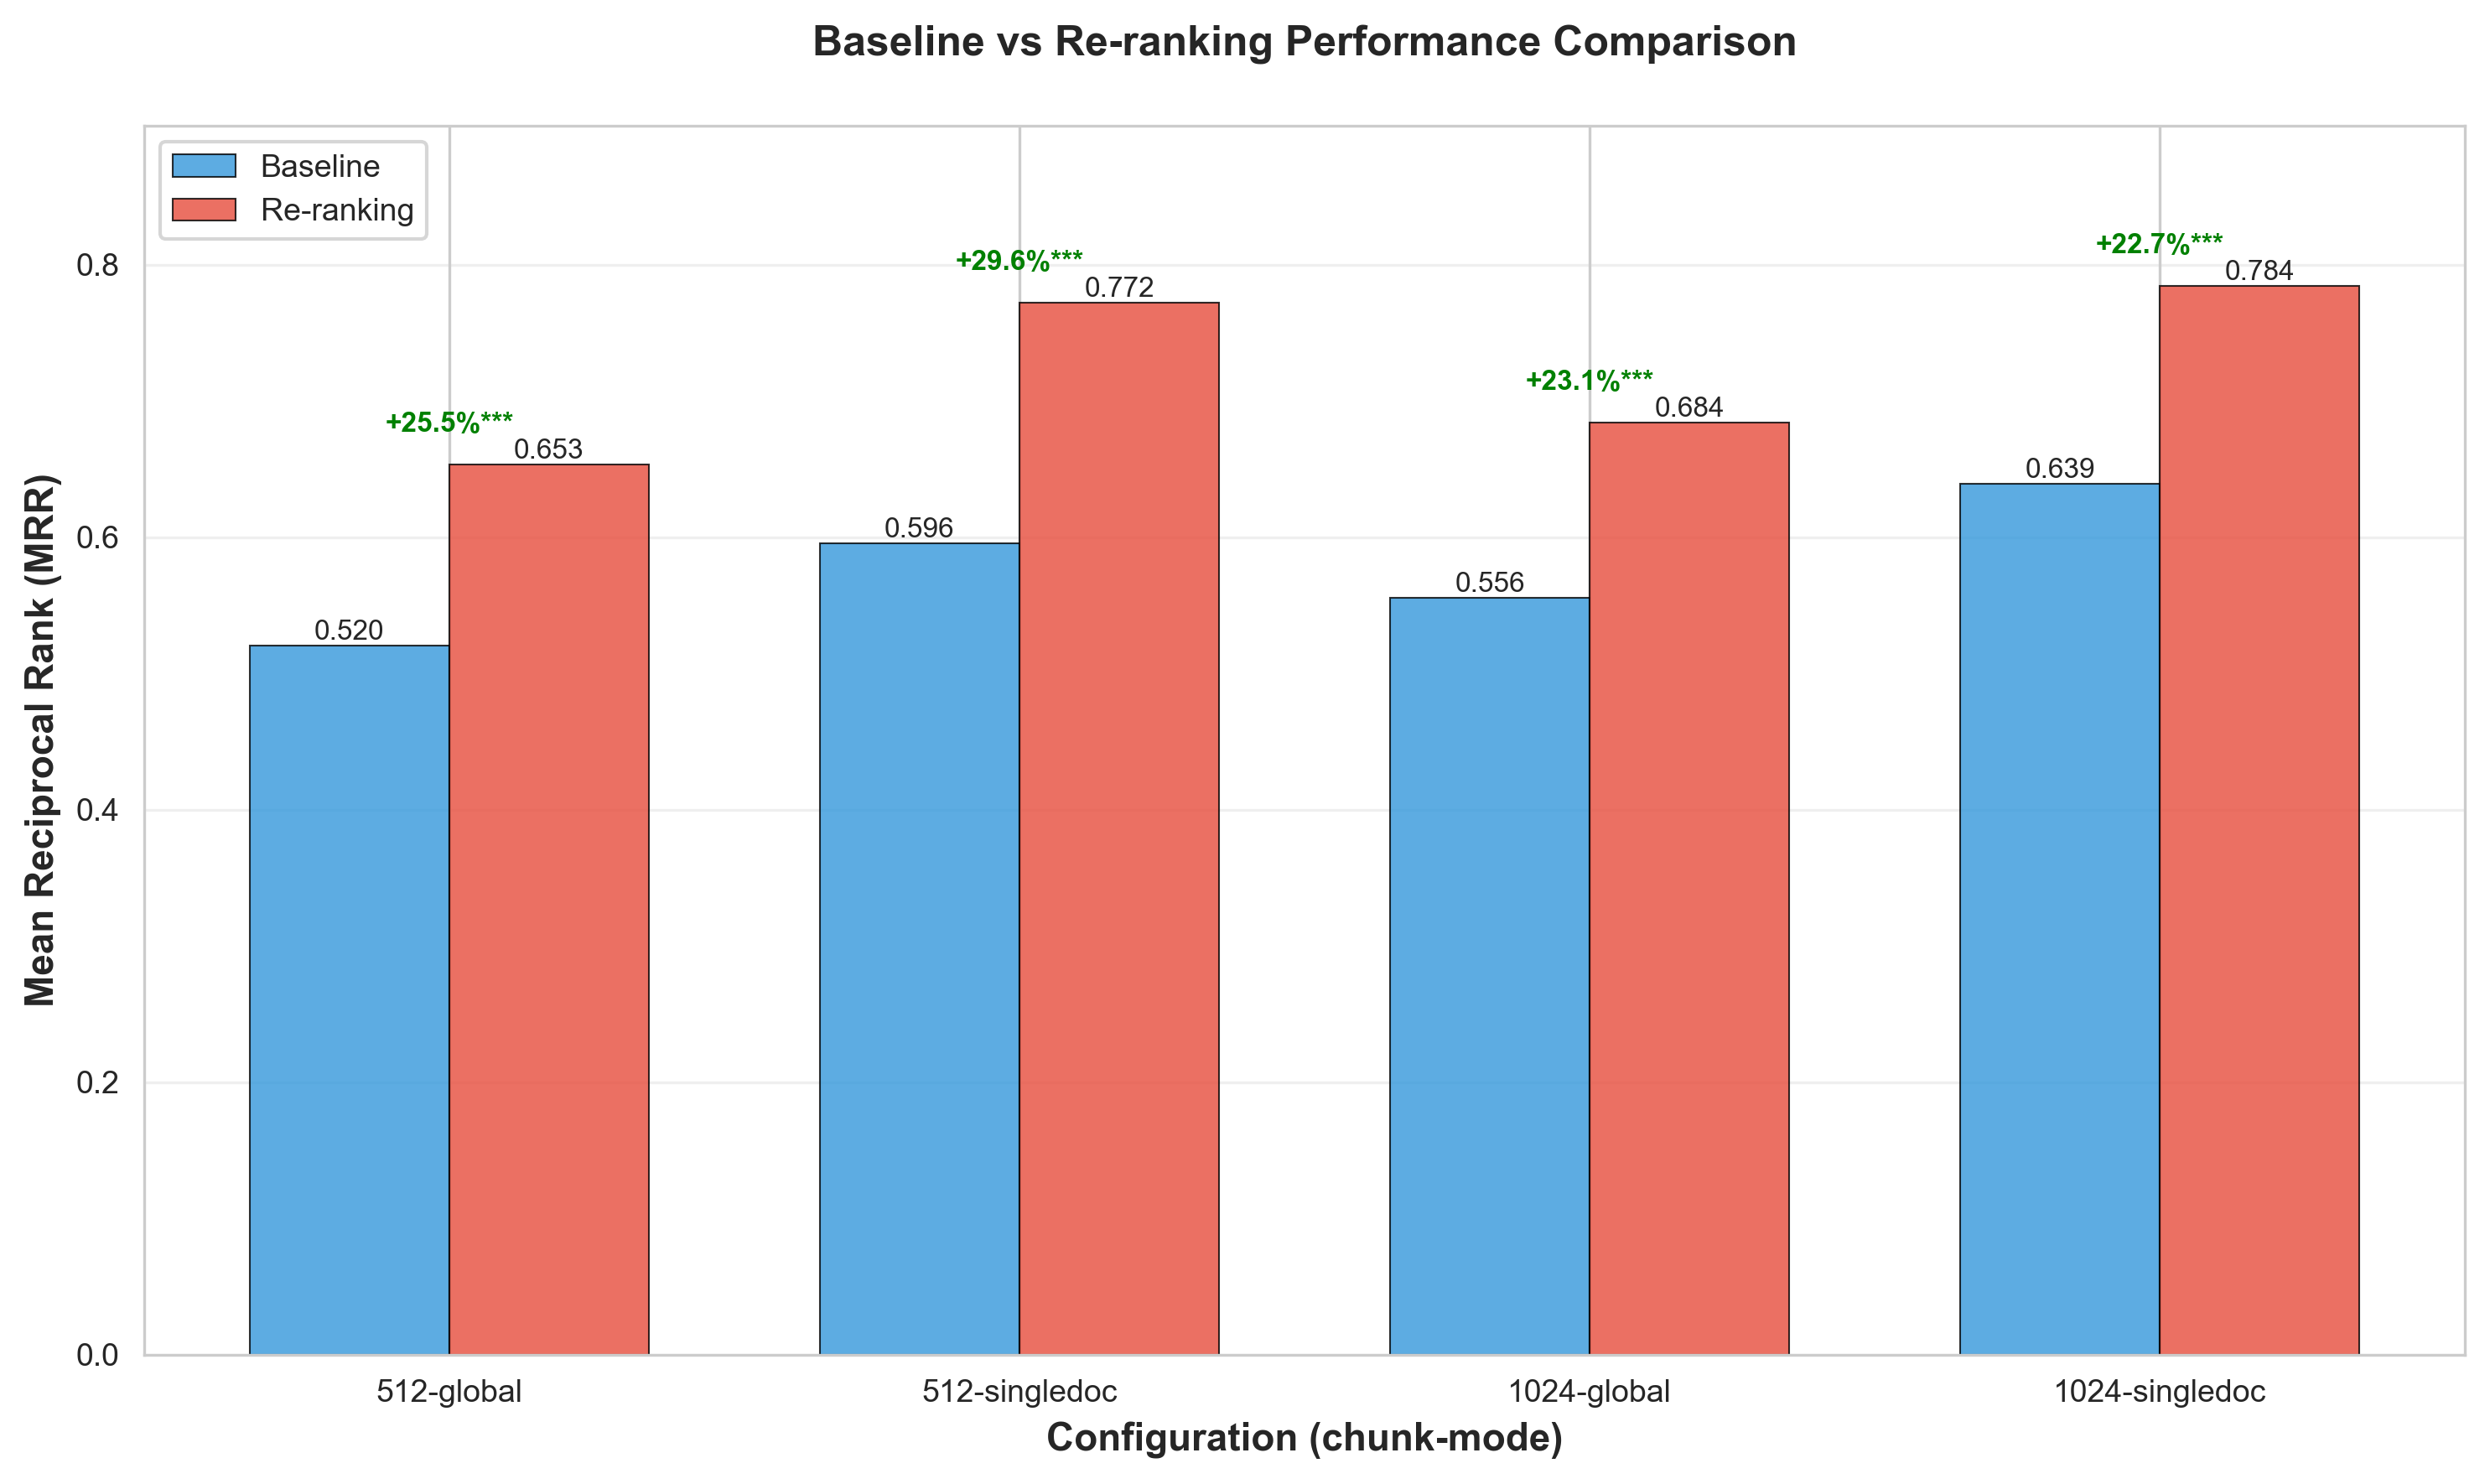

✓ Saved plot to: ../../evaluation_results/reranking/plots/fig_improvement_heatmap.png


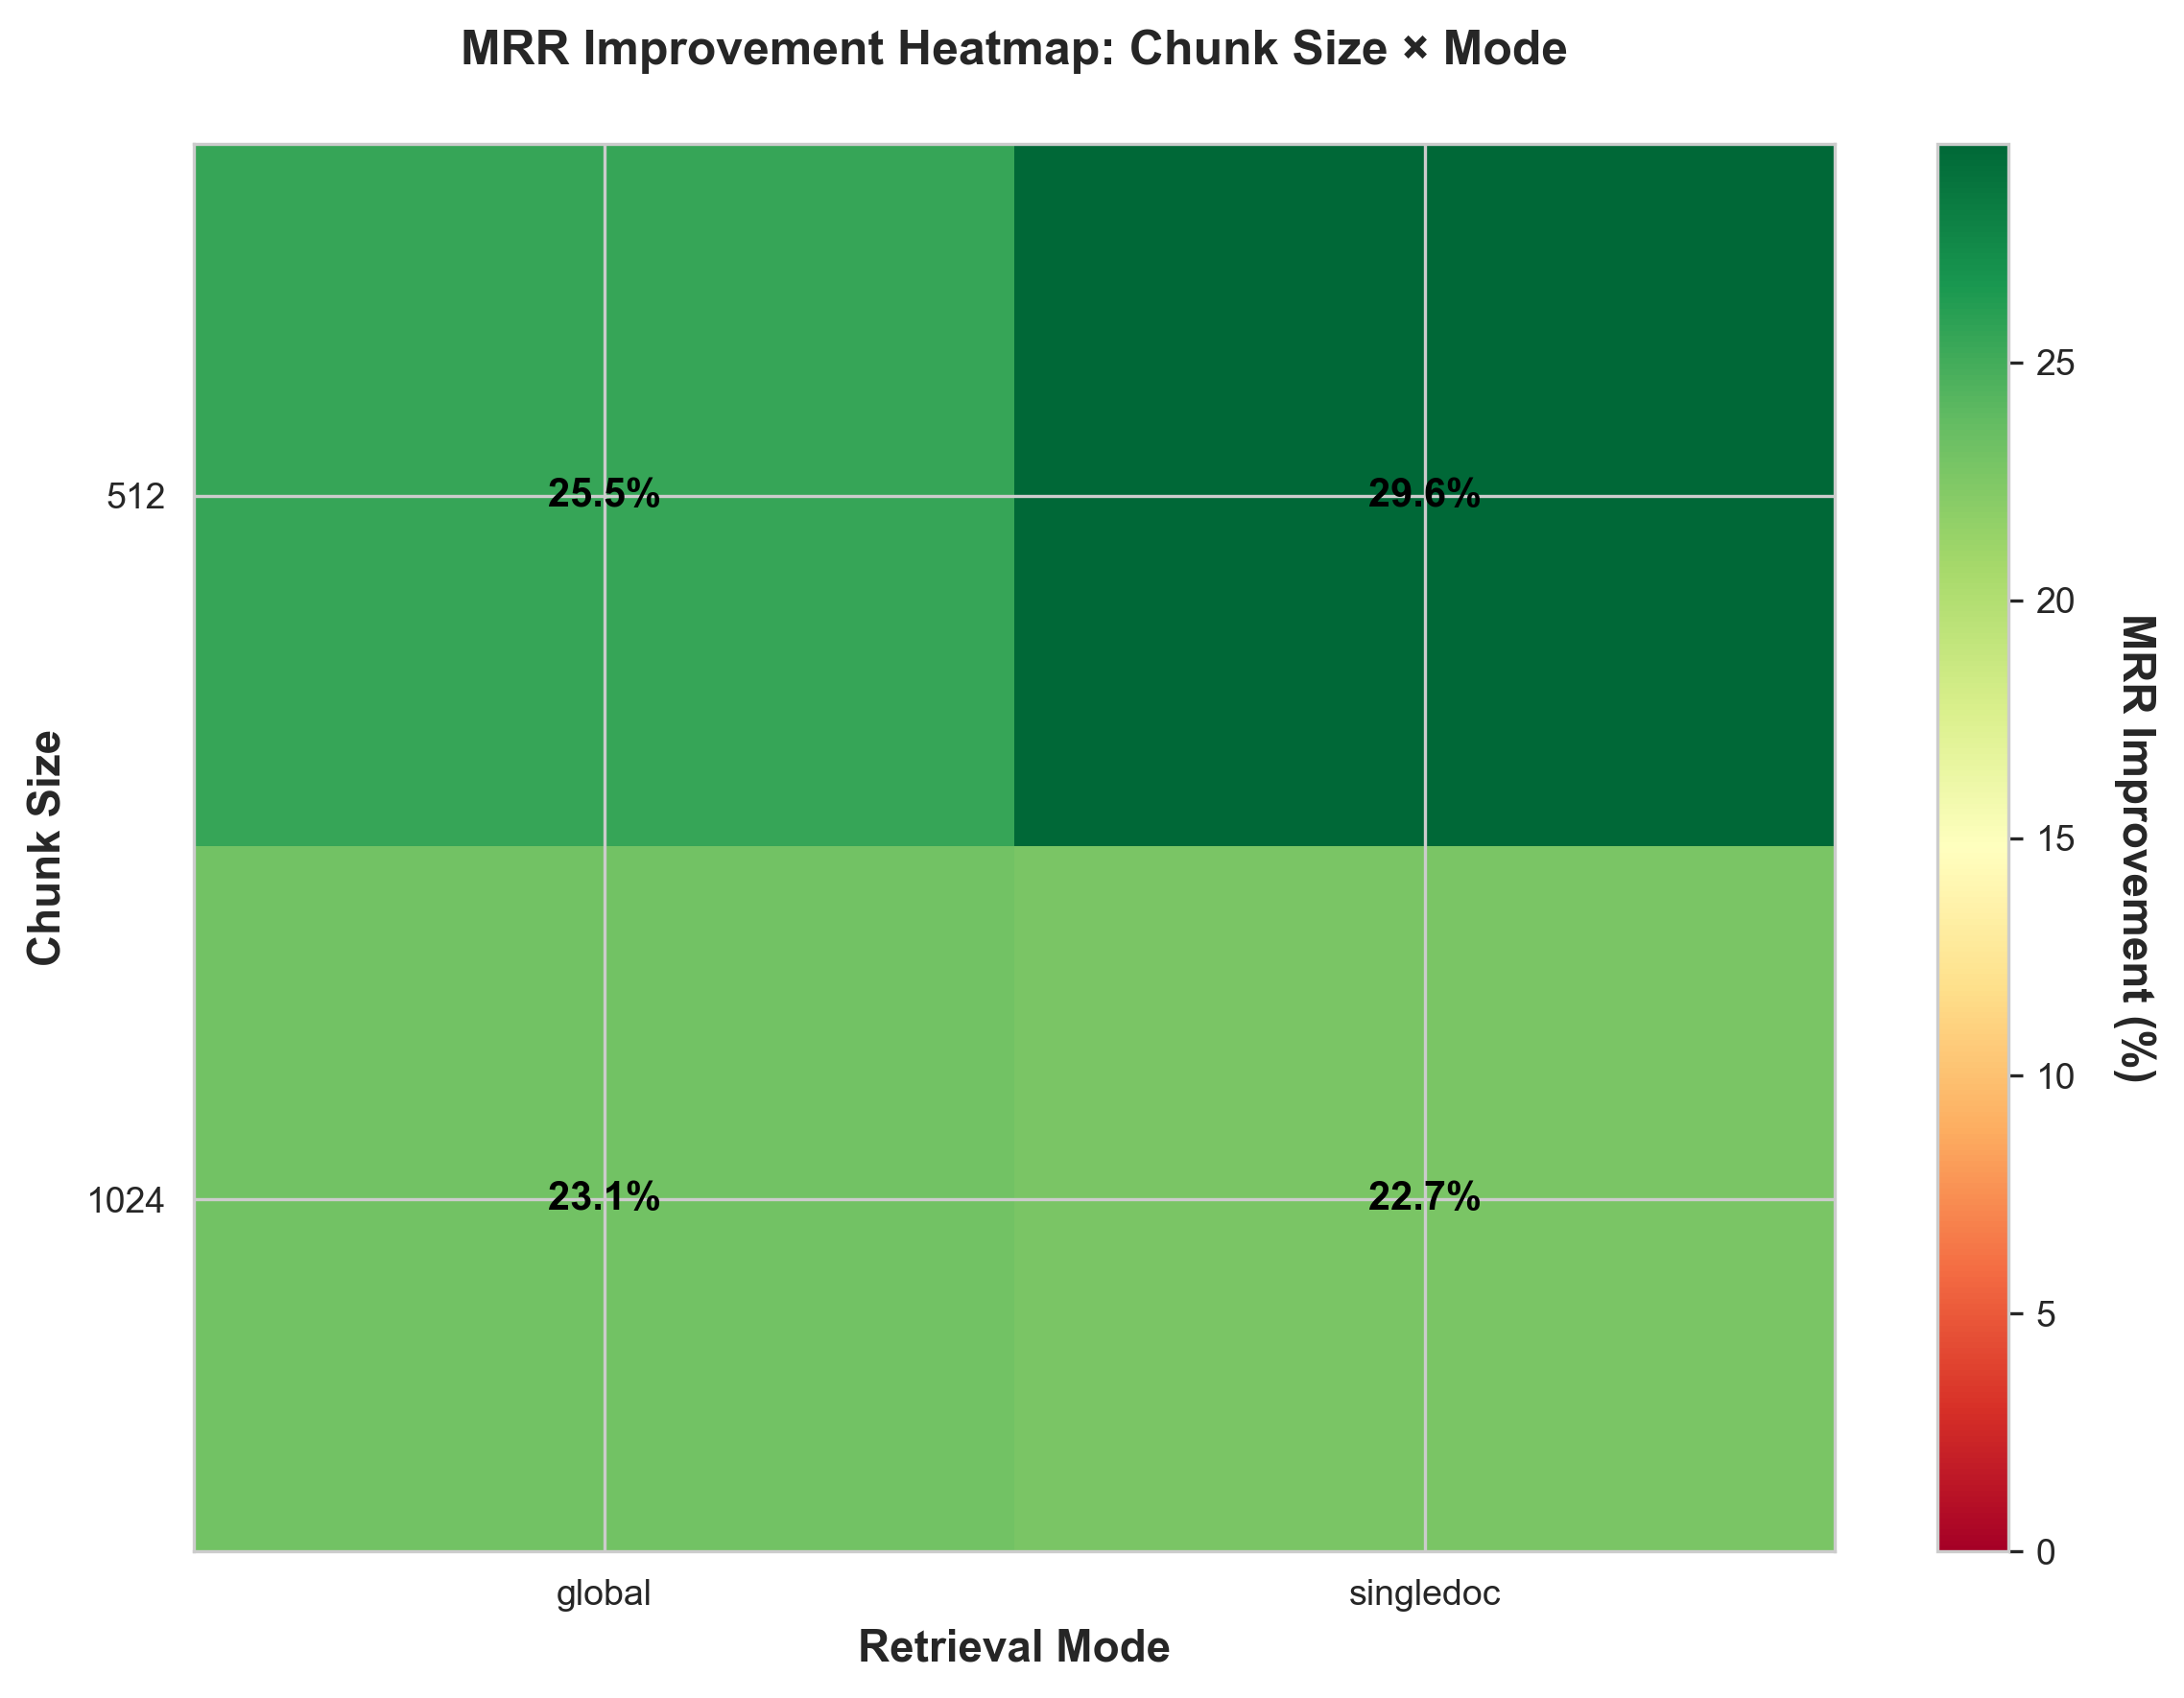

✓ Saved plot to: ../../evaluation_results/reranking/plots/fig_question_types.png


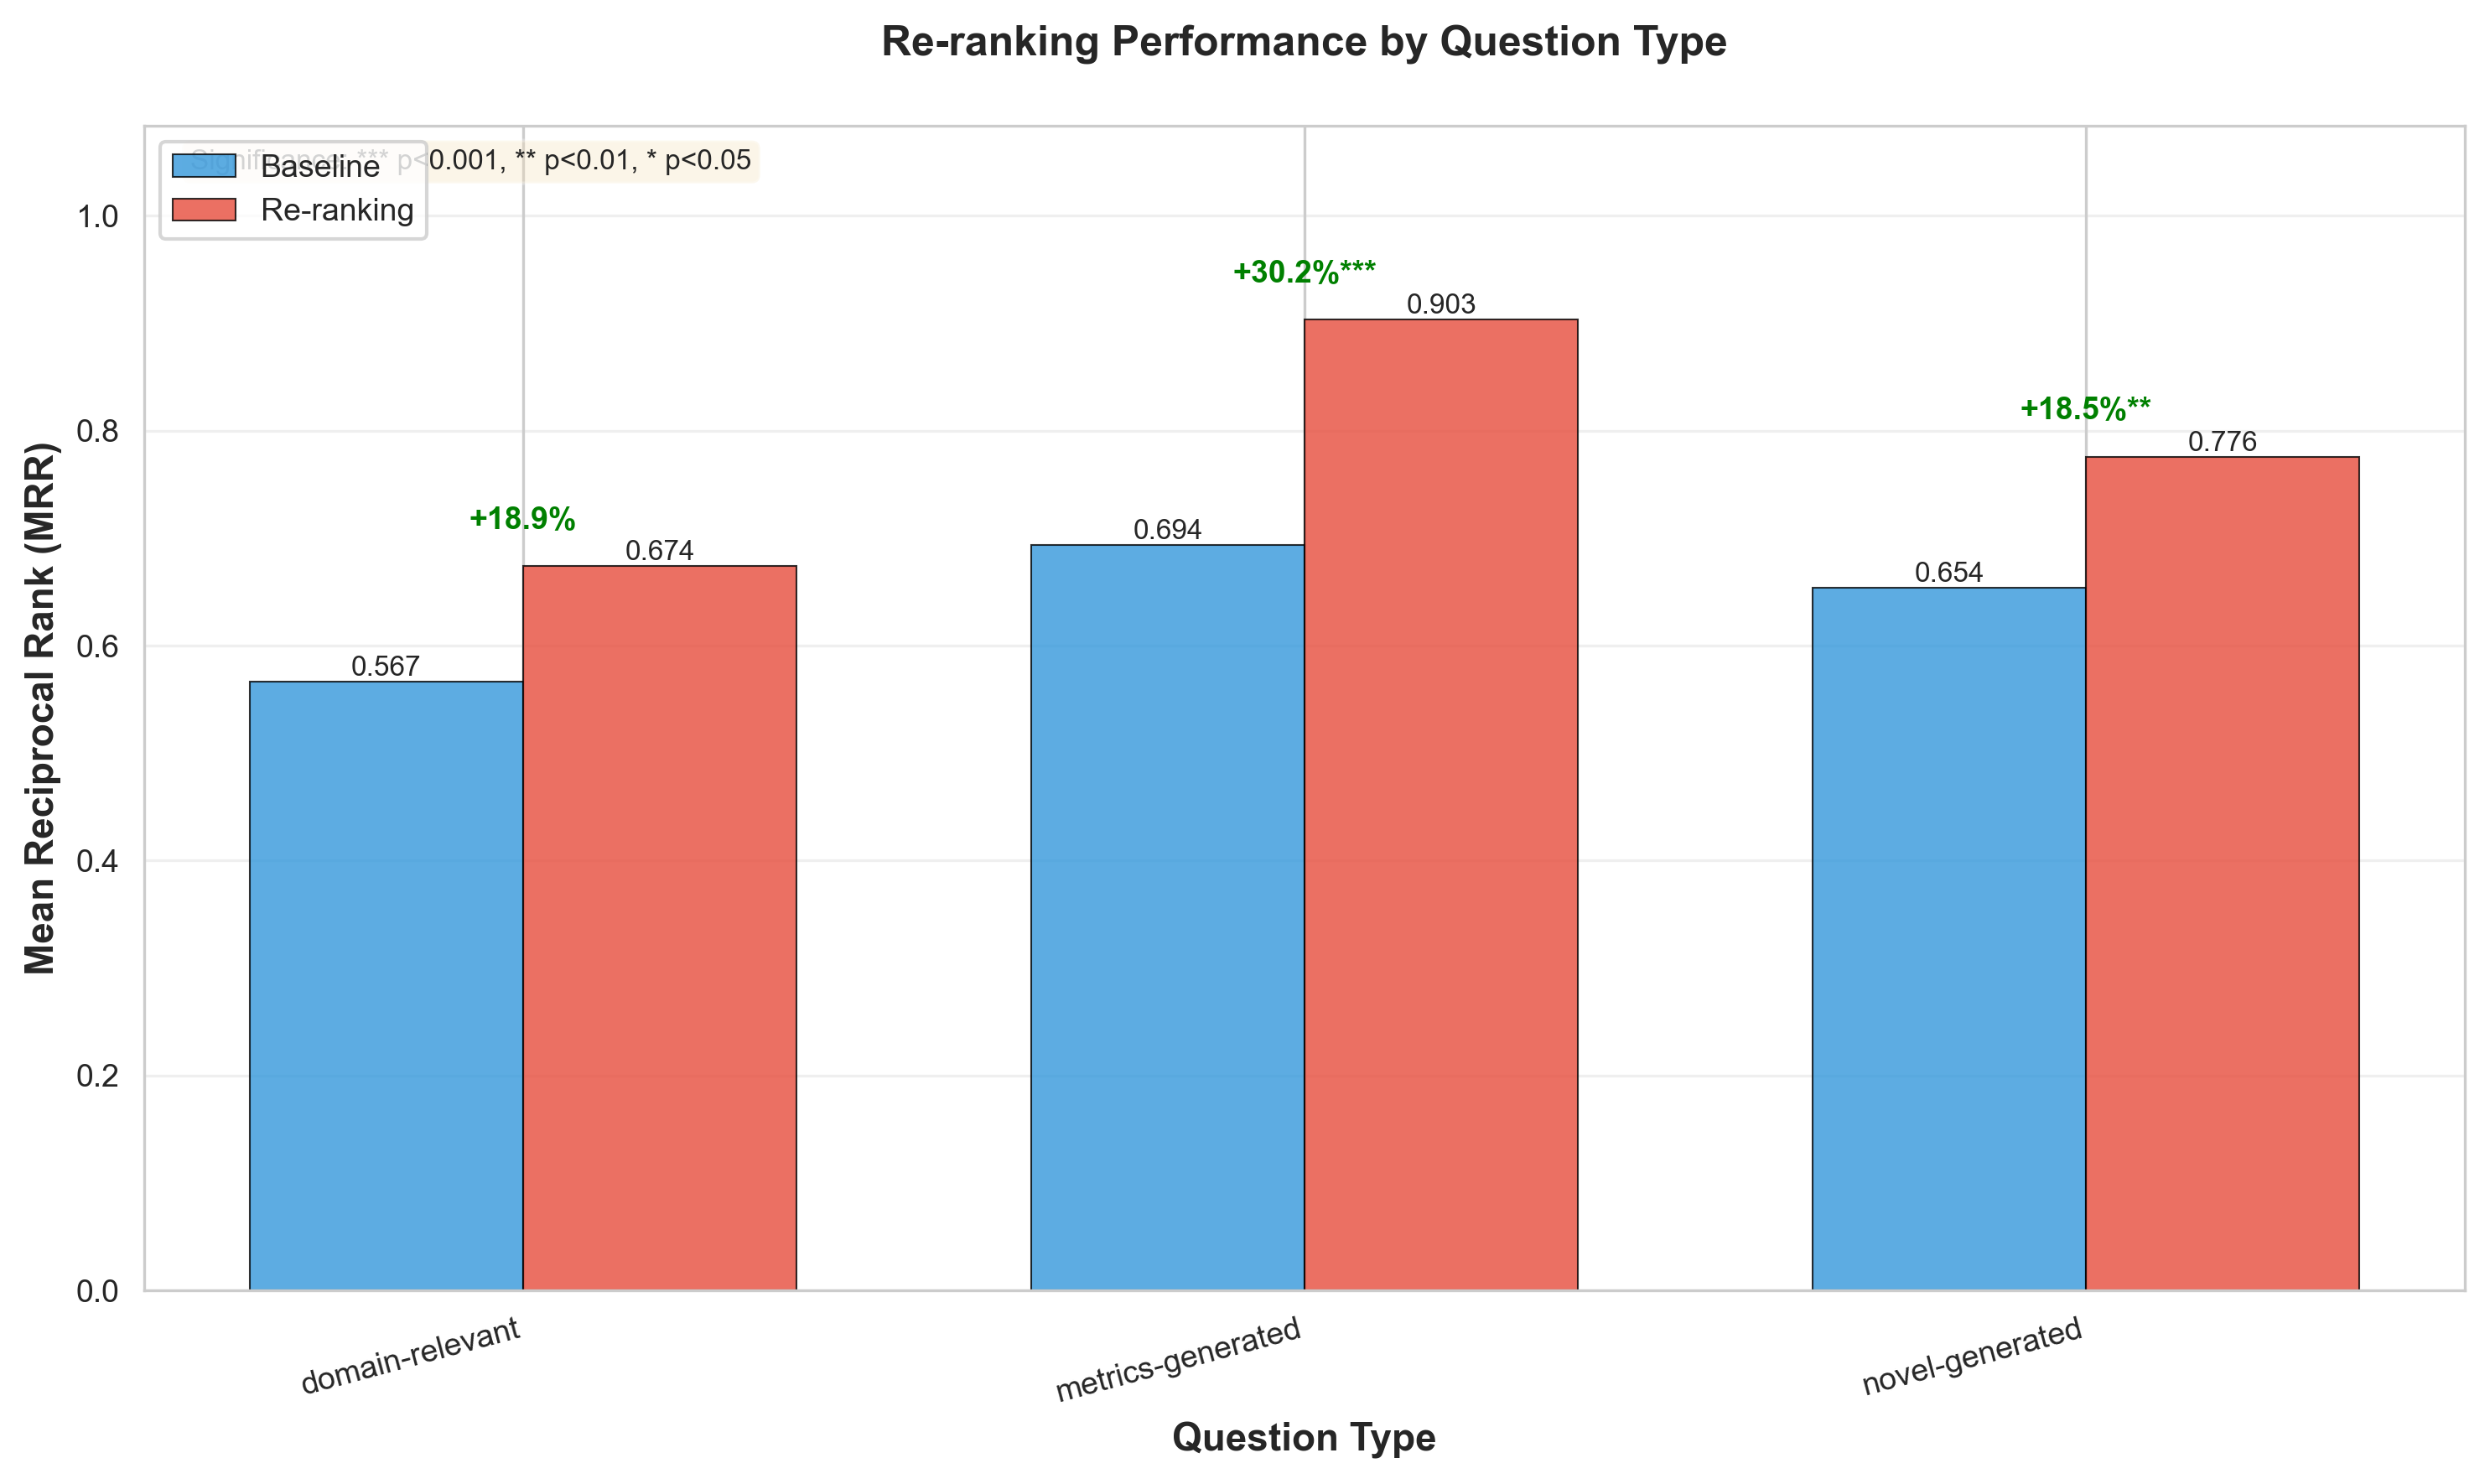

✓ Saved plot to: ../../evaluation_results/reranking/plots/fig_rank_distribution.png


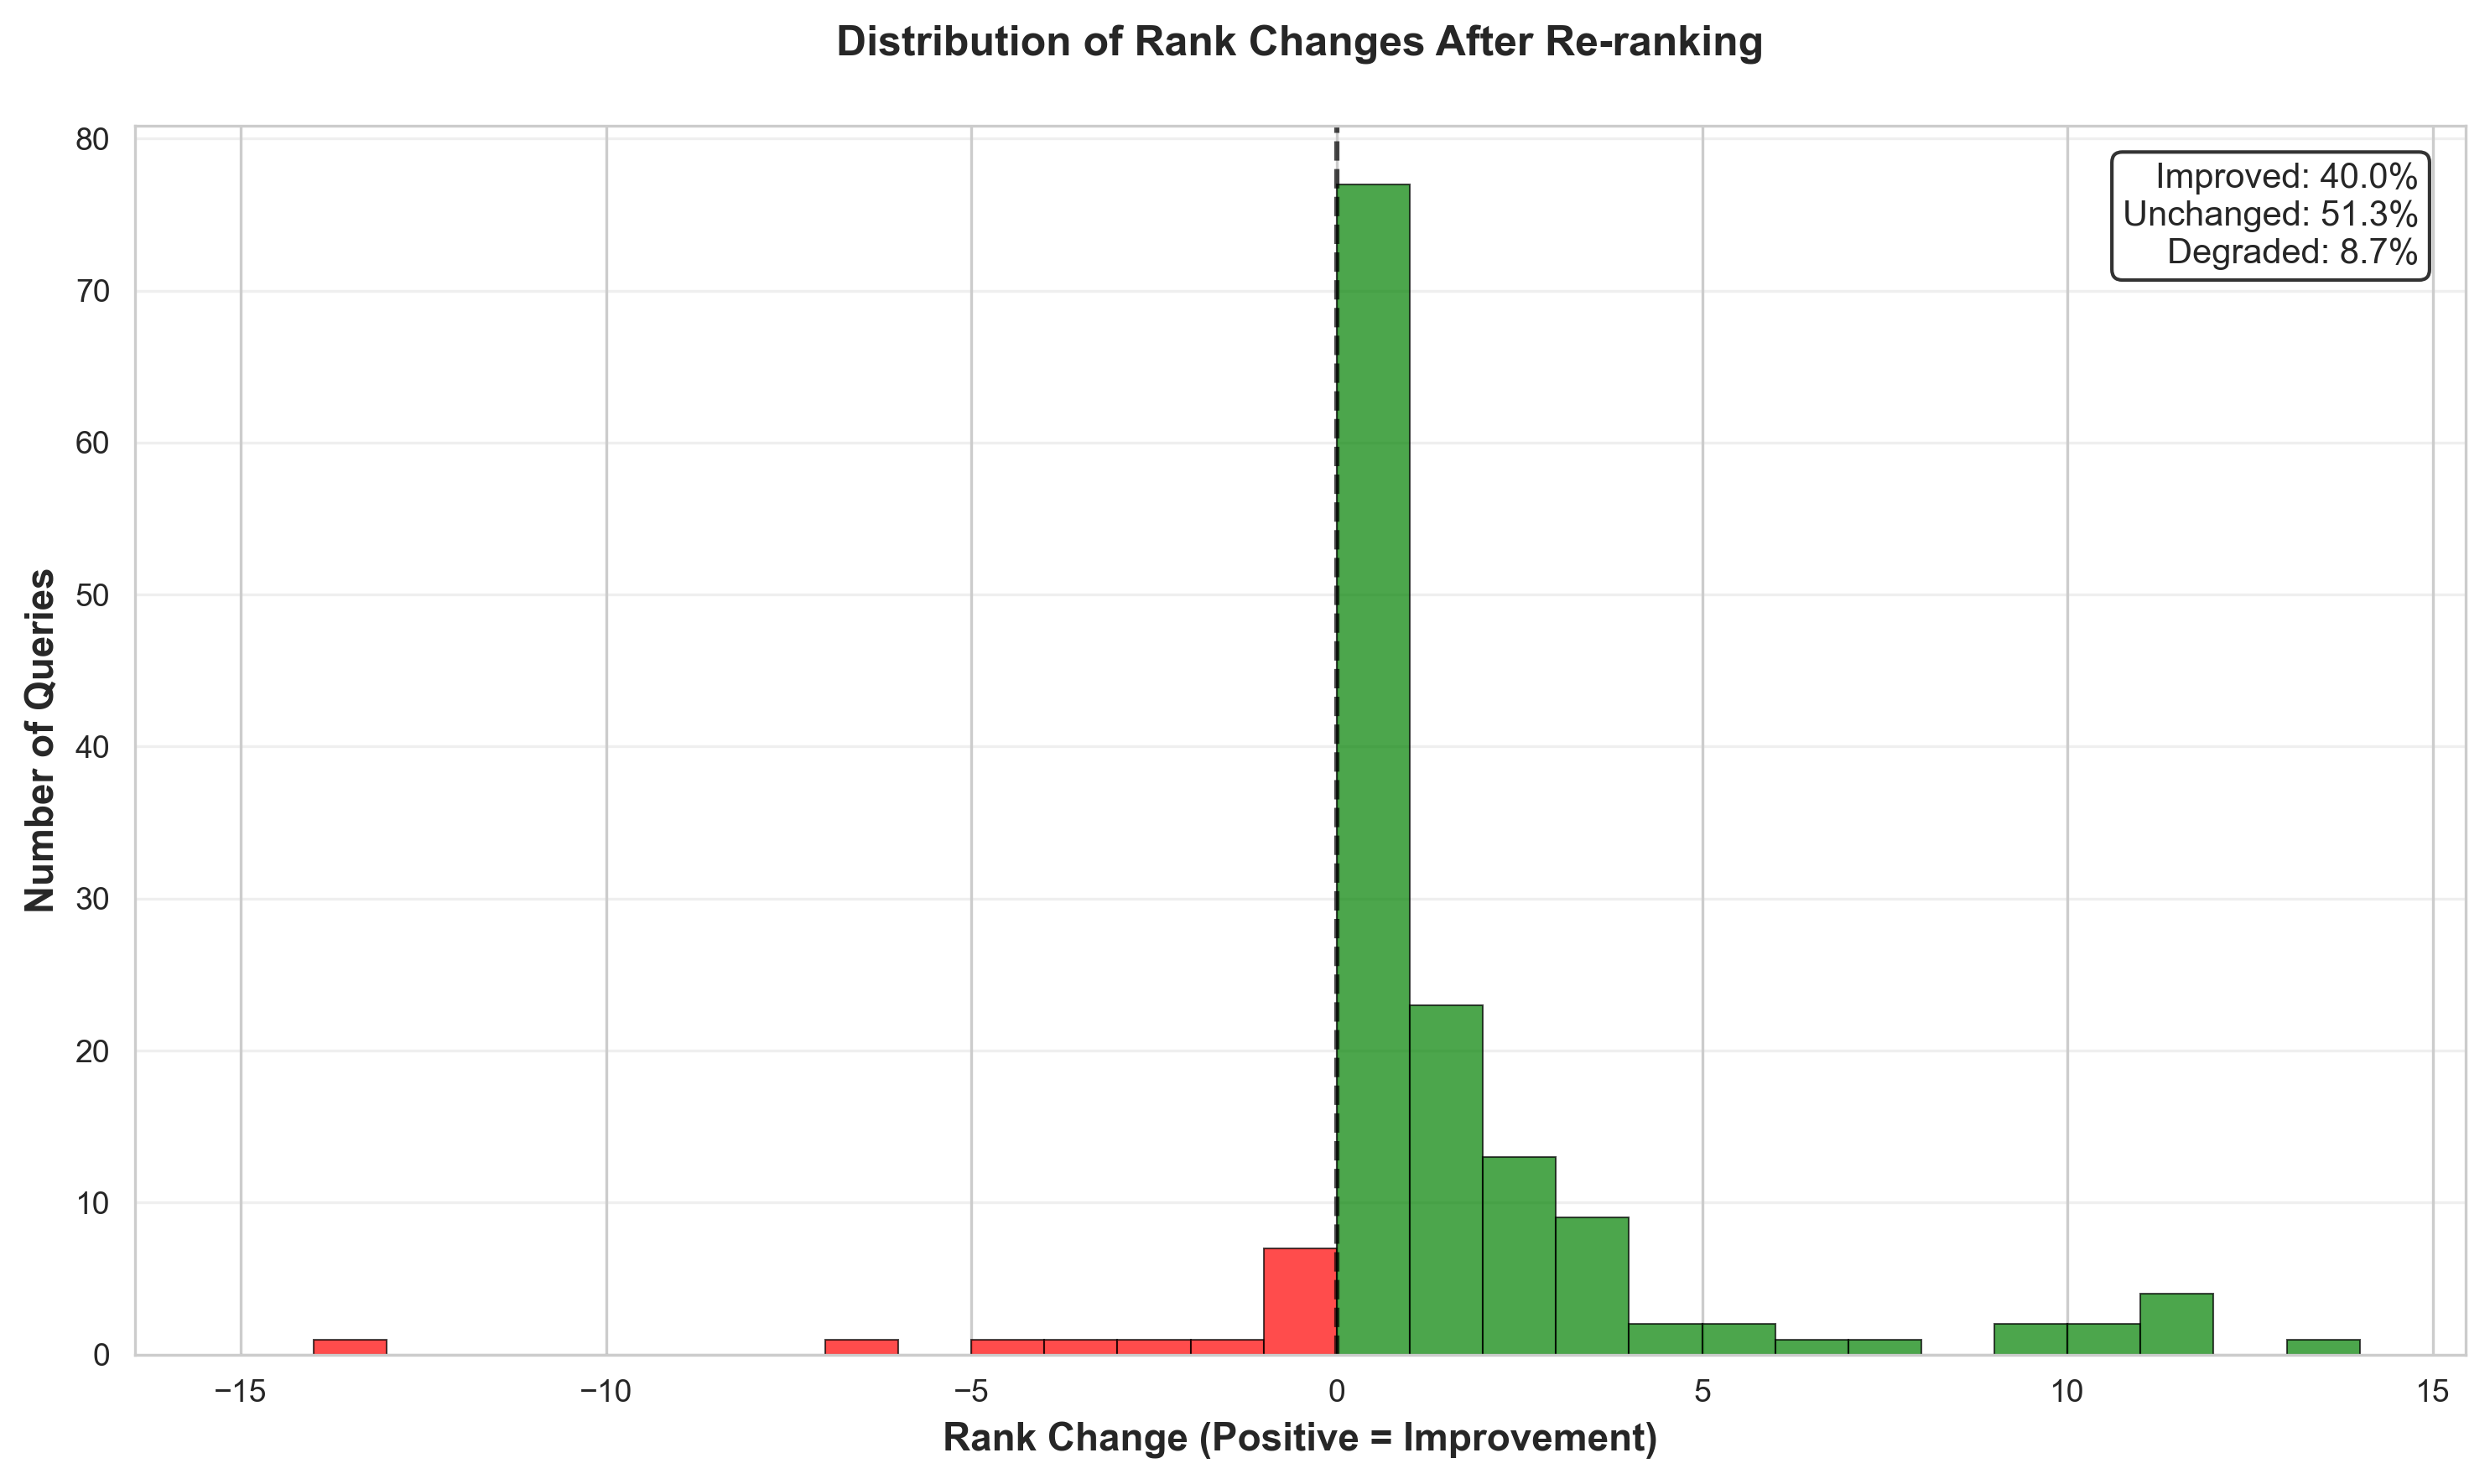

✓ Saved plot to: ../../evaluation_results/reranking/plots/fig_scatter.png


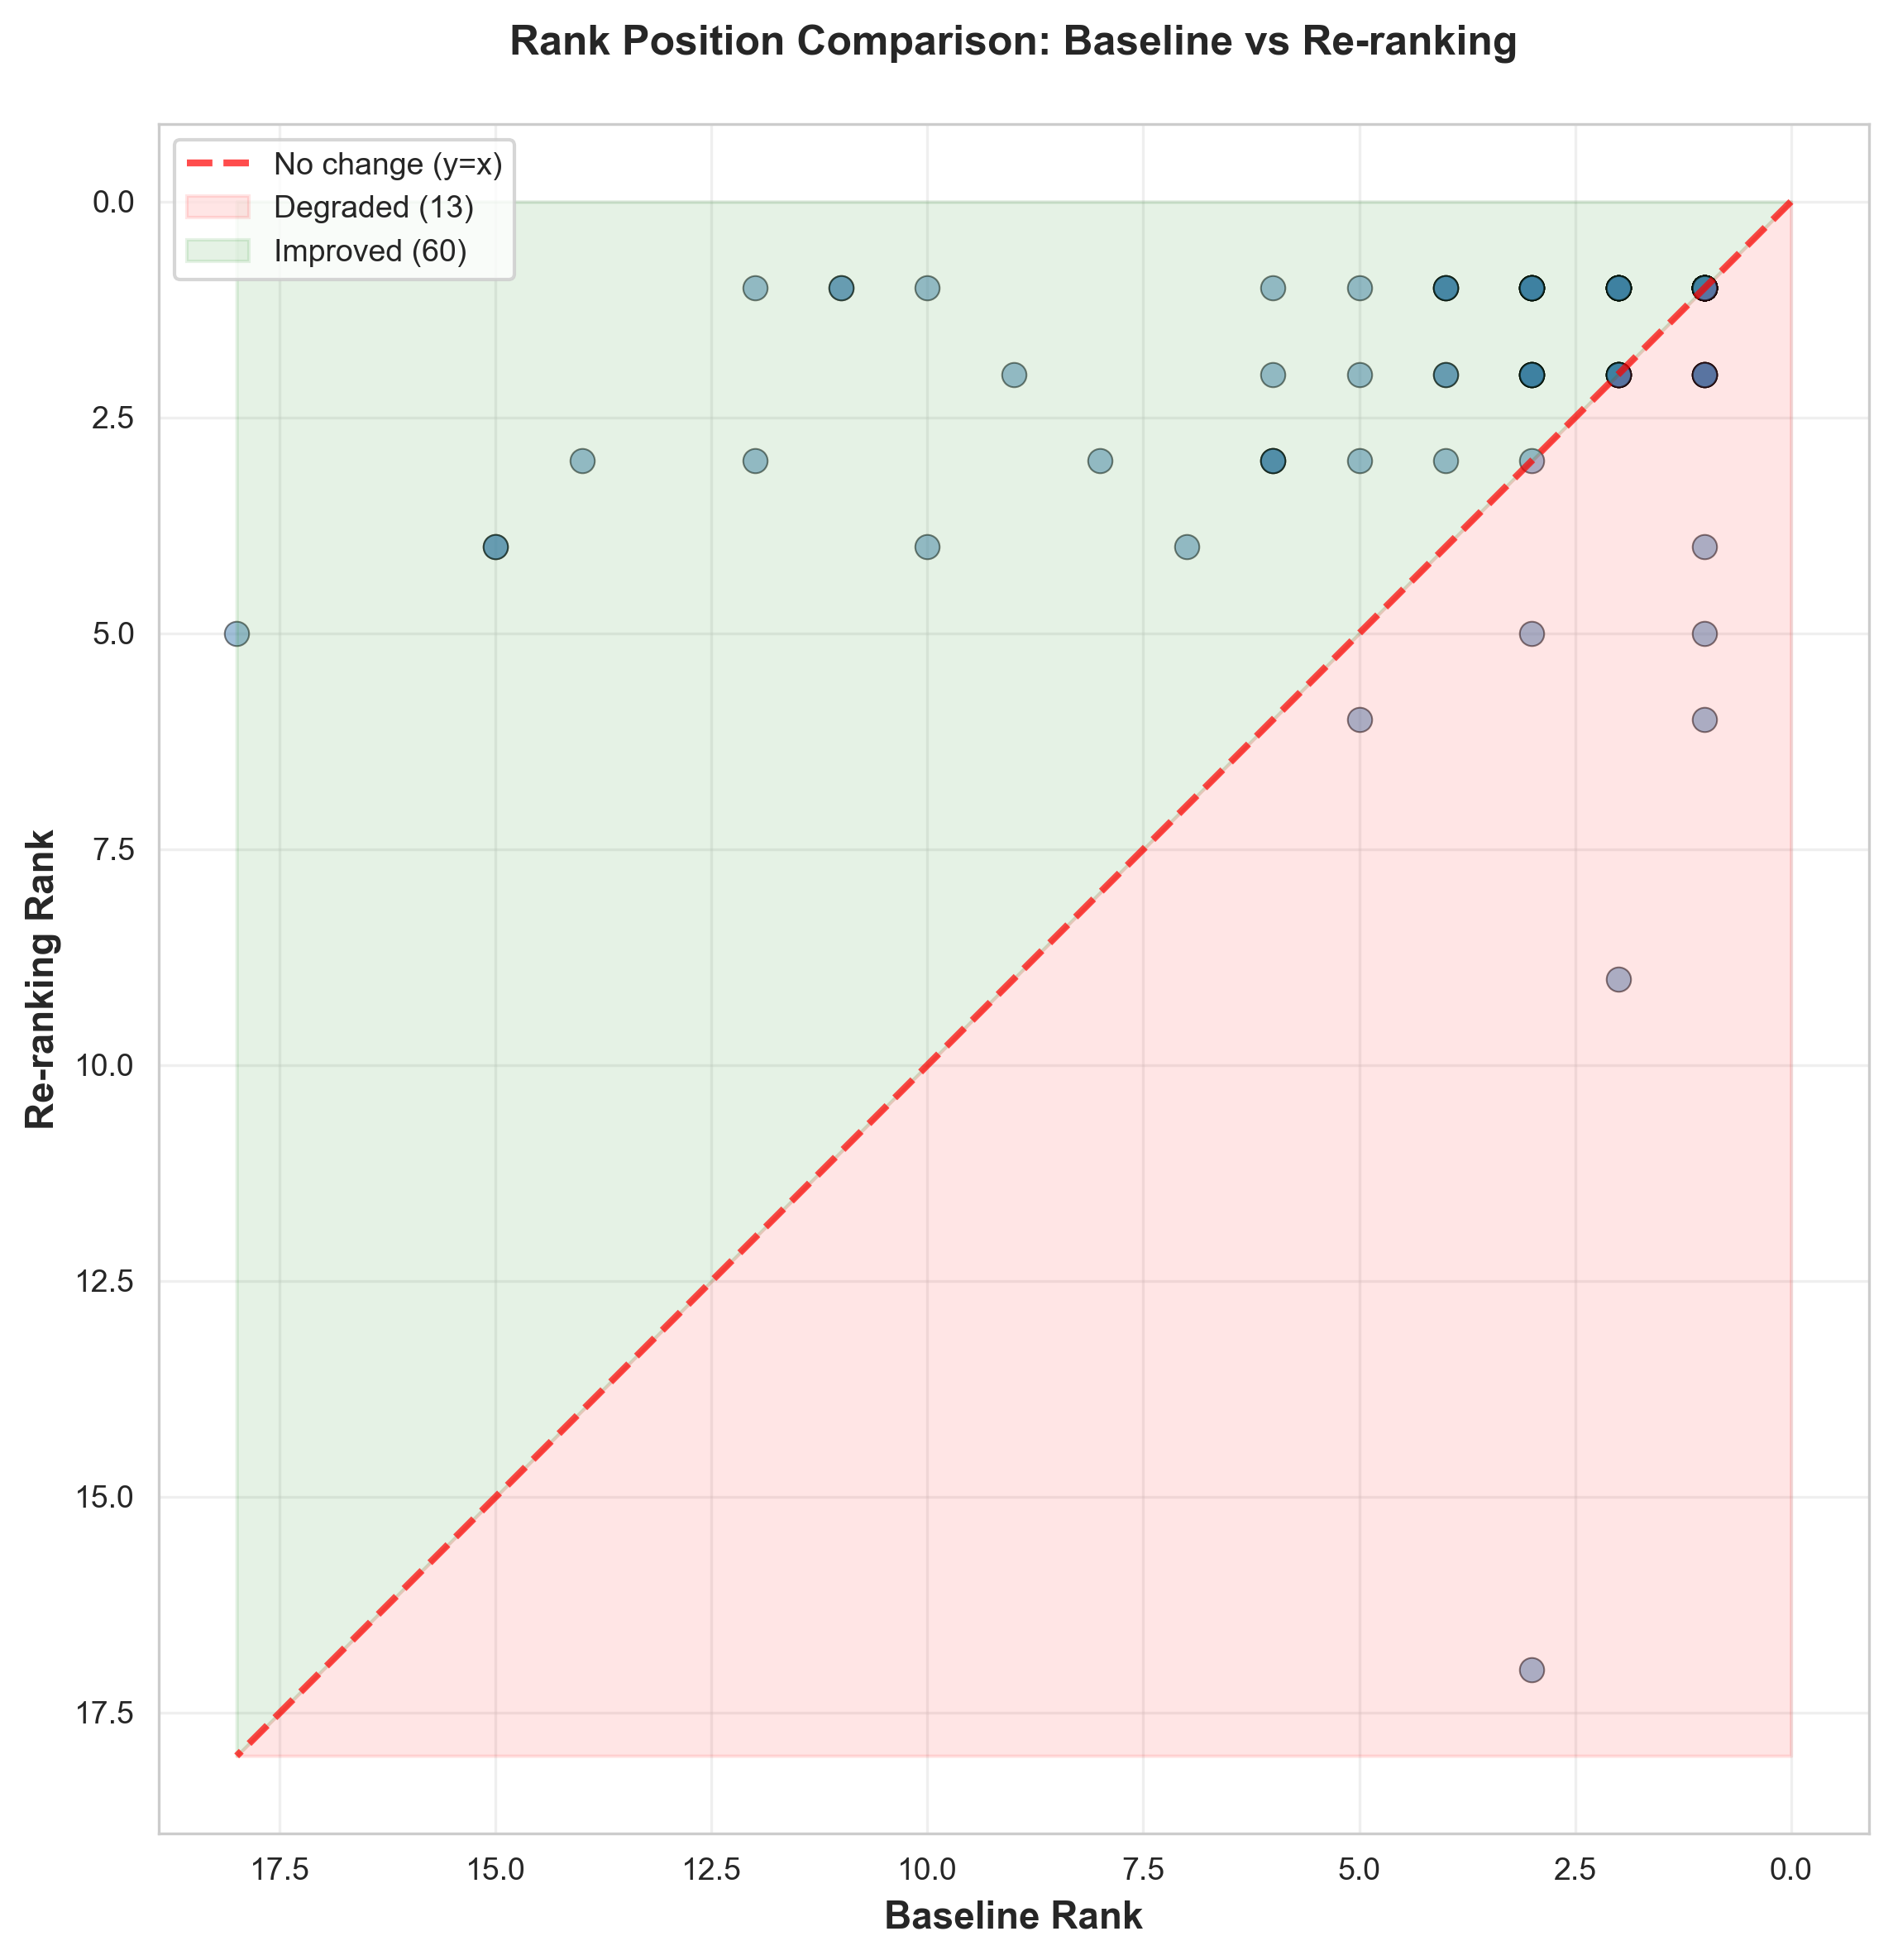

✓ Saved summary figure to: ../../evaluation_results/reranking/plots/fig_summary.png


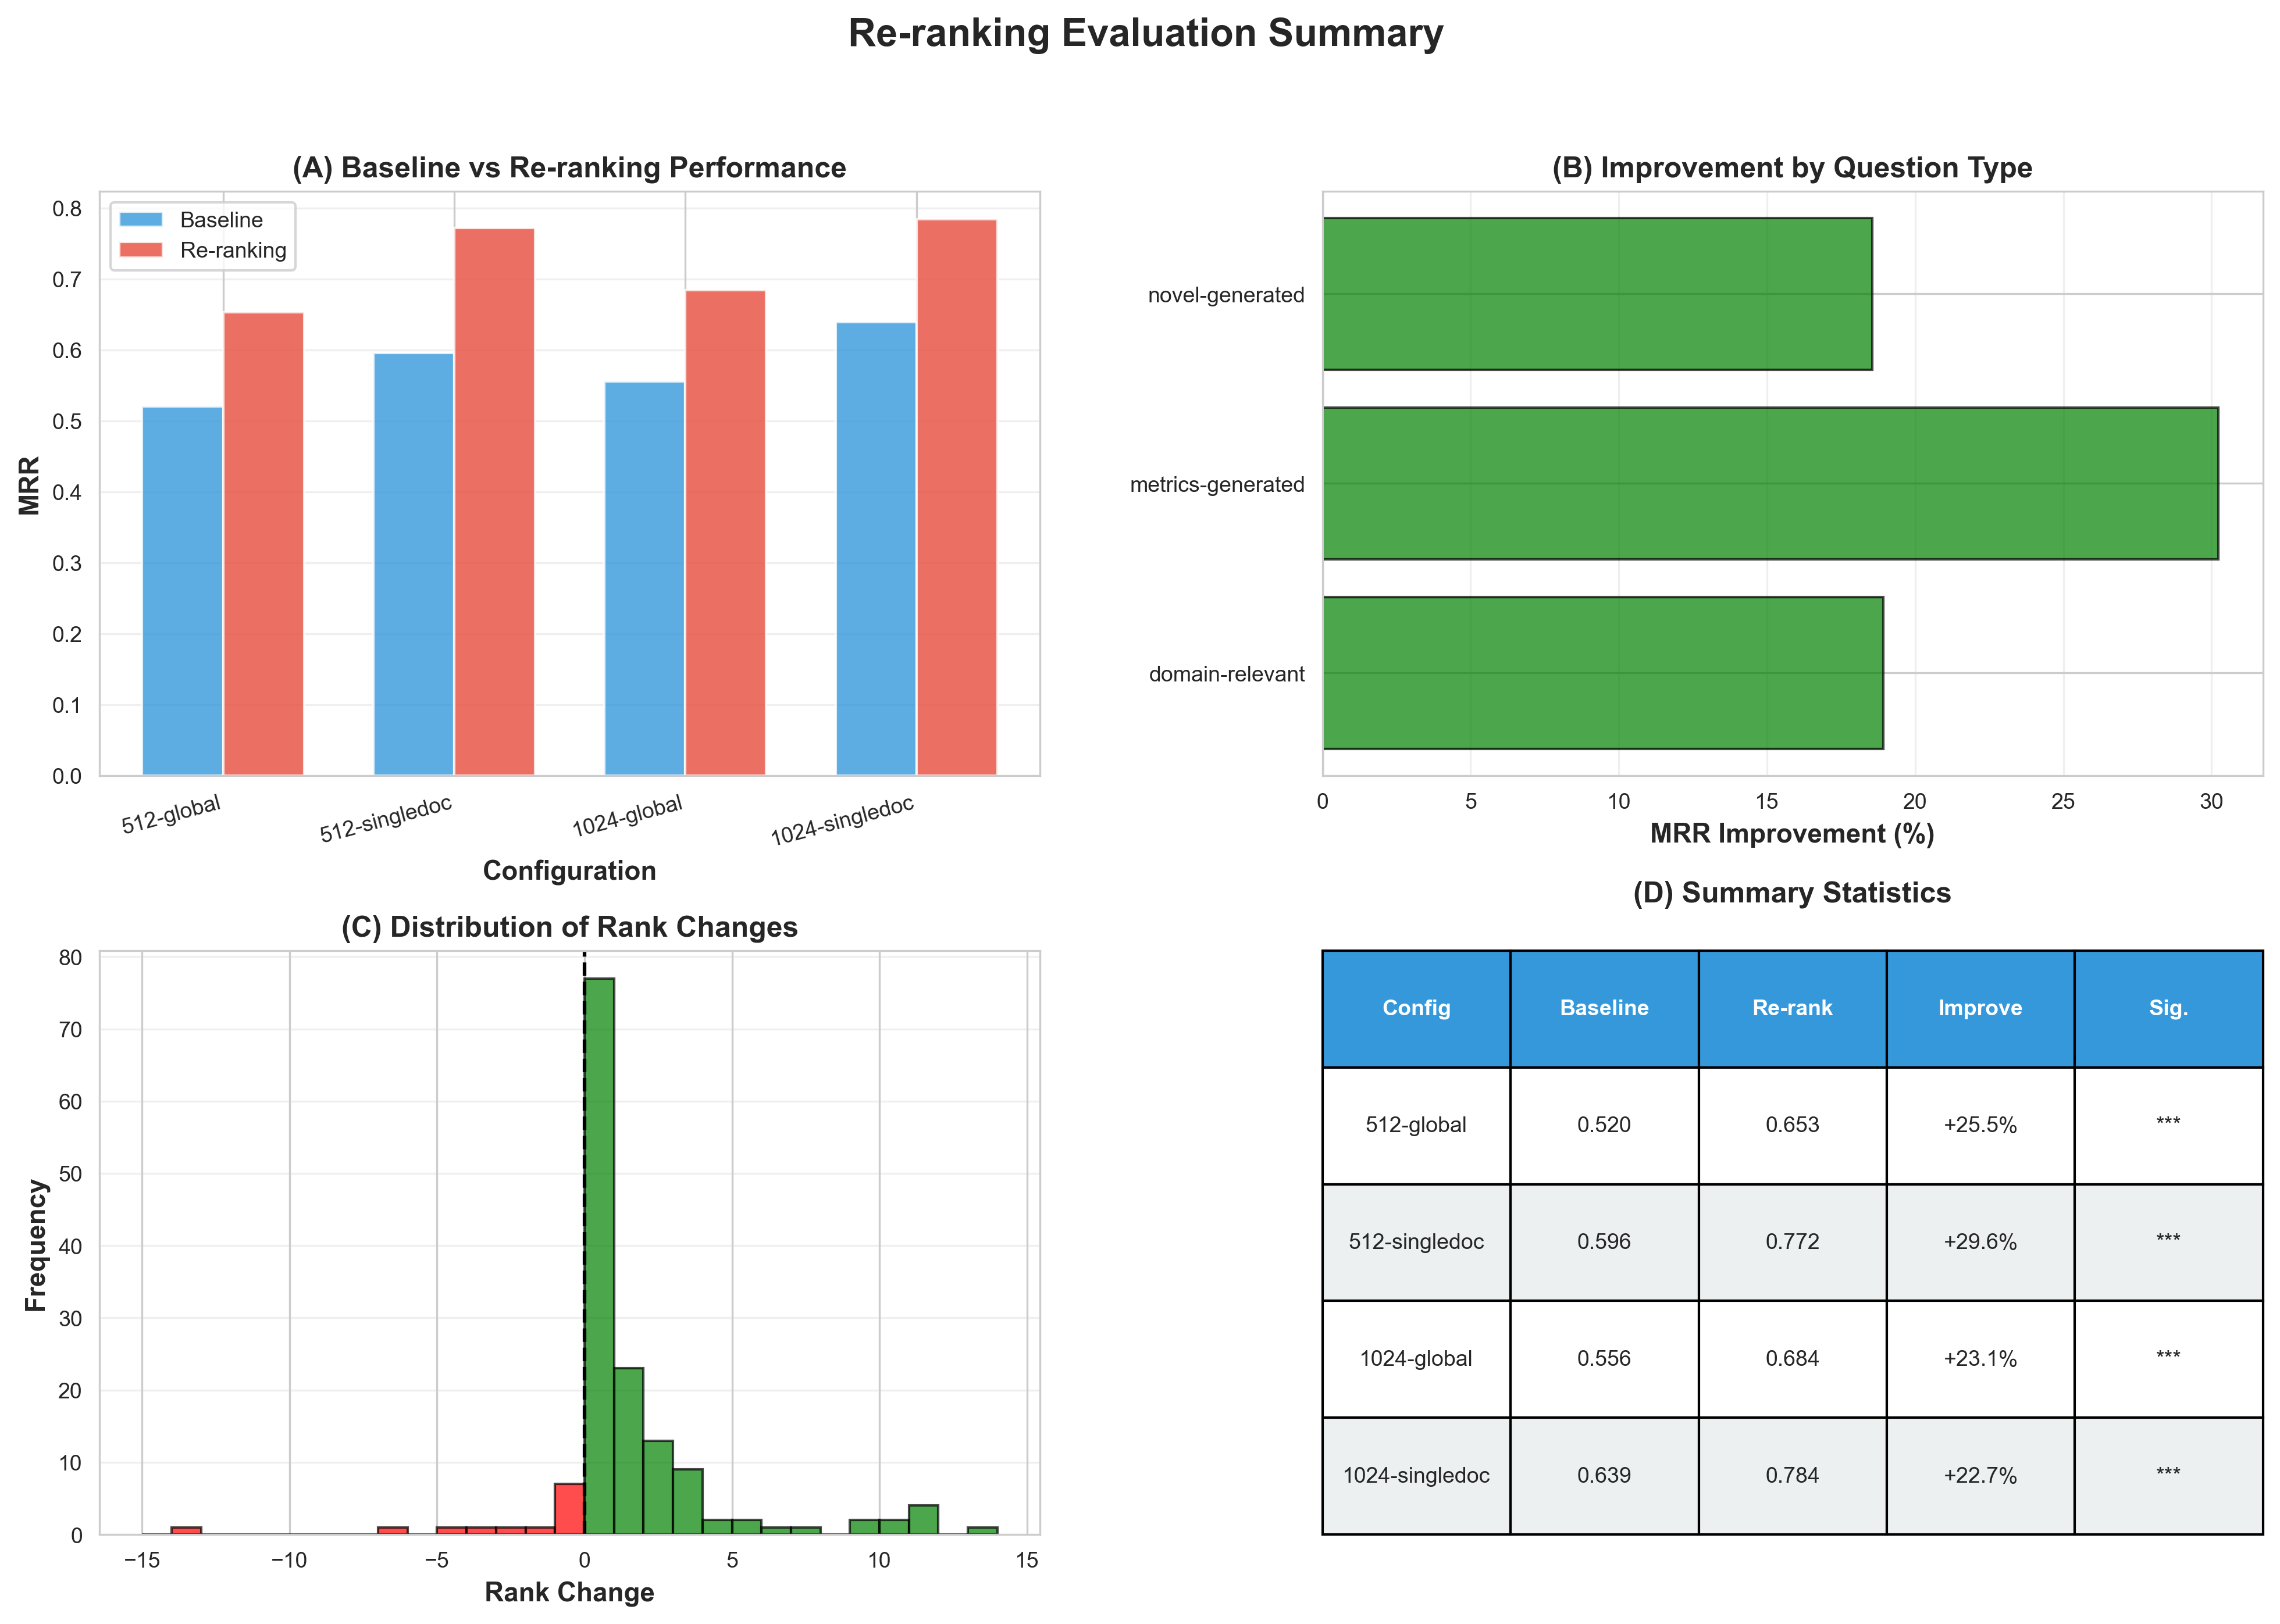


STEP 8 READY FOR USE!

Uncomment the examples above to create visualizations.
All plots are publication-quality (300 DPI) and can be saved as PNG files.


In [33]:
# ============================================================================
# Step 8: Visualization & Comparison
# ============================================================================

# %% [markdown]
# ## Step 8.1: Import Visualization Libraries

# %%
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for publication-quality plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

print("✓ Visualization libraries imported")

# %% [markdown]
# ## Step 8.2: Baseline vs Re-ranking Comparison (Bar Chart)

# %%
def plot_baseline_vs_reranking(all_stats, output_file=None):
    """
    Create bar chart comparing baseline vs re-ranking MRR.
    
    Args:
        all_stats: List of statistics from compare_configurations()
        output_file: Optional filename to save plot
    """
    if not all_stats:
        print("No statistics to plot")
        return
    
    # Prepare data
    config_names = [s['config_name'] for s in all_stats]
    baseline_mrrs = [s['avg_baseline'] for s in all_stats]
    rerank_mrrs = [s['avg_rerank'] for s in all_stats]
    
    # Shorten config names for display
    short_names = []
    for name in config_names:
        # Extract key info: "chunk=512, mode=global" -> "512-global"
        parts = name.split(', ')
        chunk = parts[1].replace('chunk=', '')
        mode = parts[2].replace('mode=', '')
        short_names.append(f"{chunk}-{mode}")
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(short_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, baseline_mrrs, width, label='Baseline', 
                   color='#3498db', alpha=0.8, edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, rerank_mrrs, width, label='Re-ranking', 
                   color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)
    
    # Add improvement percentage labels
    for i, stat in enumerate(all_stats):
        improvement_pct = stat['improvement_pct']
        y_pos = max(baseline_mrrs[i], rerank_mrrs[i]) + 0.02
        
        # Add significance stars
        p_val = stat['p_value']
        if p_val < 0.001:
            sig = "***"
        elif p_val < 0.01:
            sig = "**"
        elif p_val < 0.05:
            sig = "*"
        else:
            sig = ""
        
        ax.text(x[i], y_pos, f'+{improvement_pct:.1f}%{sig}',
               ha='center', va='bottom', fontsize=8, fontweight='bold', color='green')
    
    # Formatting
    ax.set_xlabel('Configuration (chunk-mode)', fontweight='bold')
    ax.set_ylabel('Mean Reciprocal Rank (MRR)', fontweight='bold')
    ax.set_title('Baseline vs Re-ranking Performance Comparison', fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(short_names, rotation=0)
    ax.legend(loc='upper left')
    ax.set_ylim(0, max(max(baseline_mrrs), max(rerank_mrrs)) * 1.15)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"✓ Saved plot to: {output_file}")
    
    plt.show()

print("✓ Baseline vs re-ranking plot function defined")

# %% [markdown]
# ## Step 8.3: Improvement Heatmap (Chunk × Mode)

# %%
def plot_improvement_heatmap(all_stats, output_file=None):
    """
    Create heatmap showing improvement percentage by chunk size and mode.
    
    Args:
        all_stats: List of statistics from compare_configurations()
        output_file: Optional filename to save plot
    """
    if not all_stats:
        print("No statistics to plot")
        return
    
    # Extract chunk sizes and modes
    chunk_sizes = []
    modes = []
    improvements = {}
    
    for stat in all_stats:
        config = stat['config']
        chunk = config['chunk_size']
        mode = config['mode']
        improvement_pct = stat['improvement_pct']
        
        if chunk not in chunk_sizes:
            chunk_sizes.append(chunk)
        if mode not in modes:
            modes.append(mode)
        
        improvements[(chunk, mode)] = improvement_pct
    
    # Sort
    chunk_sizes = sorted(chunk_sizes)
    modes = sorted(modes)
    
    # Create matrix
    data = np.zeros((len(chunk_sizes), len(modes)))
    for i, chunk in enumerate(chunk_sizes):
        for j, mode in enumerate(modes):
            data[i, j] = improvements.get((chunk, mode), 0)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    
    im = ax.imshow(data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=max(improvements.values()))
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('MRR Improvement (%)', rotation=270, labelpad=20, fontweight='bold')
    
    # Set ticks
    ax.set_xticks(np.arange(len(modes)))
    ax.set_yticks(np.arange(len(chunk_sizes)))
    ax.set_xticklabels(modes)
    ax.set_yticklabels(chunk_sizes)
    
    # Add text annotations
    for i in range(len(chunk_sizes)):
        for j in range(len(modes)):
            text = ax.text(j, i, f'{data[i, j]:.1f}%',
                          ha="center", va="center", color="black", fontweight='bold')
    
    # Labels
    ax.set_xlabel('Retrieval Mode', fontweight='bold')
    ax.set_ylabel('Chunk Size', fontweight='bold')
    ax.set_title('MRR Improvement Heatmap: Chunk Size × Mode', fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"✓ Saved plot to: {output_file}")
    
    plt.show()

print("✓ Improvement heatmap function defined")

# %% [markdown]
# ## Step 8.4: Question Type Performance (Bar Chart)

# %%
def plot_question_type_performance(type_stats, output_file=None):
    """
    Create bar chart showing performance by question type.
    
    Args:
        type_stats: Output from analyze_by_question_type()
        output_file: Optional filename to save plot
    """
    if not type_stats:
        print("No question type statistics to plot")
        return
    
    # Prepare data
    question_types = [s['question_type'] for s in type_stats]
    baseline_mrrs = [s['avg_baseline'] for s in type_stats]
    rerank_mrrs = [s['avg_rerank'] for s in type_stats]
    p_values = [s['p_value'] for s in type_stats]
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(question_types))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, baseline_mrrs, width, label='Baseline', 
                   color='#3498db', alpha=0.8, edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, rerank_mrrs, width, label='Re-ranking', 
                   color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=8)
    
    # Add improvement and significance
    for i, stat in enumerate(type_stats):
        improvement_pct = stat['improvement_pct']
        p_val = stat['p_value']
        
        y_pos = max(baseline_mrrs[i], rerank_mrrs[i]) + 0.03
        
        # Significance marker
        if p_val < 0.001:
            sig = "***"
        elif p_val < 0.01:
            sig = "**"
        elif p_val < 0.05:
            sig = "*"
        else:
            sig = ""
        
        color = 'green' if improvement_pct > 0 else 'red'
        ax.text(x[i], y_pos, f'{improvement_pct:+.1f}%{sig}',
               ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)
    
    # Formatting
    ax.set_xlabel('Question Type', fontweight='bold')
    ax.set_ylabel('Mean Reciprocal Rank (MRR)', fontweight='bold')
    ax.set_title('Re-ranking Performance by Question Type', fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(question_types, rotation=15, ha='right')
    ax.legend(loc='upper left')
    ax.set_ylim(0, max(max(baseline_mrrs), max(rerank_mrrs)) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    # Add note
    ax.text(0.02, 0.98, 'Significance: *** p<0.001, ** p<0.01, * p<0.05',
           transform=ax.transAxes, fontsize=8, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"✓ Saved plot to: {output_file}")
    
    plt.show()

print("✓ Question type performance plot function defined")

# %% [markdown]
# ## Step 8.5: Rank Improvement Distribution (Histogram)

# %%
def plot_rank_improvement_distribution(improvements, output_file=None):
    """
    Create histogram of rank improvements.
    
    Args:
        improvements: List of rank improvements from analyze_rank_movements()
        output_file: Optional filename to save plot
    """
    if not improvements:
        print("No improvements data to plot")
        return
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create histogram
    bins = range(min(improvements)-1, max(improvements)+2, 1)
    n, bins, patches = ax.hist(improvements, bins=bins, edgecolor='black', 
                               linewidth=0.5, alpha=0.7, color='steelblue')
    
    # Color bars: green for improvements, red for degradations, gray for no change
    for i, patch in enumerate(patches):
        bin_center = (bins[i] + bins[i+1]) / 2
        if bin_center > 0:
            patch.set_facecolor('green')
            patch.set_alpha(0.7)
        elif bin_center < 0:
            patch.set_facecolor('red')
            patch.set_alpha(0.7)
        else:
            patch.set_facecolor('gray')
            patch.set_alpha(0.5)
    
    # Add vertical line at zero
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Statistics
    improved_pct = sum(1 for x in improvements if x > 0) / len(improvements) * 100
    degraded_pct = sum(1 for x in improvements if x < 0) / len(improvements) * 100
    unchanged_pct = sum(1 for x in improvements if x == 0) / len(improvements) * 100
    
    # Add text box with statistics
    stats_text = f'Improved: {improved_pct:.1f}%\nUnchanged: {unchanged_pct:.1f}%\nDegraded: {degraded_pct:.1f}%'
    ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))
    
    # Formatting
    ax.set_xlabel('Rank Change (Positive = Improvement)', fontweight='bold')
    ax.set_ylabel('Number of Queries', fontweight='bold')
    ax.set_title('Distribution of Rank Changes After Re-ranking', fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"✓ Saved plot to: {output_file}")
    
    plt.show()

print("✓ Rank improvement distribution plot function defined")

# %% [markdown]
# ## Step 8.6: Baseline vs Re-rank Scatter Plot

# %%
def plot_baseline_vs_rerank_scatter(baseline_queries, rerank_queries, output_file=None):
    """
    Create scatter plot showing baseline rank vs re-rank rank.
    
    Args:
        baseline_queries: Baseline query results
        rerank_queries: Re-ranking query results
        output_file: Optional filename to save plot
    """
    # Extract ranks (only for queries where we have valid ranks)
    baseline_ranks = []
    rerank_ranks = []
    
    for rq in rerank_queries:
        baseline_rank = rq.get('rank_baseline', -1)
        rerank_rank = rq.get('rank', -1)
        
        if baseline_rank > 0 and rerank_rank > 0:
            baseline_ranks.append(baseline_rank)
            rerank_ranks.append(rerank_rank)
    
    if not baseline_ranks:
        print("No valid rank data to plot")
        return
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Scatter plot
    ax.scatter(baseline_ranks, rerank_ranks, alpha=0.5, s=50, color='steelblue', edgecolor='black', linewidth=0.5)
    
    # Add diagonal line (y=x) - represents no change
    max_rank = max(max(baseline_ranks), max(rerank_ranks))
    ax.plot([0, max_rank], [0, max_rank], 'r--', linewidth=2, alpha=0.7, label='No change (y=x)')
    
    # Count improvements/degradations
    improvements = sum(1 for b, r in zip(baseline_ranks, rerank_ranks) if r < b)
    degradations = sum(1 for b, r in zip(baseline_ranks, rerank_ranks) if r > b)
    unchanged = sum(1 for b, r in zip(baseline_ranks, rerank_ranks) if r == b)
    
    # Add shaded regions
    ax.fill_between([0, max_rank], [0, max_rank], max_rank, alpha=0.1, color='red', 
                    label=f'Degraded ({degradations})')
    ax.fill_between([0, max_rank], 0, [0, max_rank], alpha=0.1, color='green', 
                    label=f'Improved ({improvements})')
    
    # Formatting
    ax.set_xlabel('Baseline Rank', fontweight='bold')
    ax.set_ylabel('Re-ranking Rank', fontweight='bold')
    ax.set_title('Rank Position Comparison: Baseline vs Re-ranking', fontweight='bold', pad=20)
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    # Invert axes (rank 1 is best, should be at top)
    ax.invert_yaxis()
    ax.invert_xaxis()
    
    plt.tight_layout()
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"✓ Saved plot to: {output_file}")
    
    plt.show()

print("✓ Baseline vs re-rank scatter plot function defined")

# %% [markdown]
# ## Step 8.7: Multi-Panel Summary Figure

# %%
def create_summary_figure(all_stats, type_stats, improvements, output_file=None):
    """
    Create a multi-panel figure with all key visualizations.
    
    Args:
        all_stats: Statistics from compare_configurations()
        type_stats: Statistics from analyze_by_question_type()
        improvements: Rank improvements list
        output_file: Optional filename to save plot
    """
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Panel 1: Baseline vs Re-ranking bars
    ax1 = fig.add_subplot(gs[0, 0])
    config_names = [s['config_name'].split(', ')[1:] for s in all_stats]
    short_names = [f"{c[0].replace('chunk=', '')}-{c[1].replace('mode=', '')}" for c in config_names]
    baseline_mrrs = [s['avg_baseline'] for s in all_stats]
    rerank_mrrs = [s['avg_rerank'] for s in all_stats]
    
    x = np.arange(len(short_names))
    width = 0.35
    ax1.bar(x - width/2, baseline_mrrs, width, label='Baseline', color='#3498db', alpha=0.8)
    ax1.bar(x + width/2, rerank_mrrs, width, label='Re-ranking', color='#e74c3c', alpha=0.8)
    ax1.set_xlabel('Configuration', fontweight='bold')
    ax1.set_ylabel('MRR', fontweight='bold')
    ax1.set_title('(A) Baseline vs Re-ranking Performance', fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(short_names, rotation=15, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Panel 2: Question type performance
    ax2 = fig.add_subplot(gs[0, 1])
    q_types = [s['question_type'] for s in type_stats]
    improvements_pct = [s['improvement_pct'] for s in type_stats]
    colors = ['green' if x > 0 else 'red' for x in improvements_pct]
    ax2.barh(q_types, improvements_pct, color=colors, alpha=0.7, edgecolor='black')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('MRR Improvement (%)', fontweight='bold')
    ax2.set_title('(B) Improvement by Question Type', fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Panel 3: Rank improvement histogram
    ax3 = fig.add_subplot(gs[1, 0])
    bins = range(min(improvements)-1, max(improvements)+2, 1)
    n, bins_edges, patches = ax3.hist(improvements, bins=bins, edgecolor='black', alpha=0.7)
    for i, patch in enumerate(patches):
        bin_center = (bins_edges[i] + bins_edges[i+1]) / 2
        if bin_center > 0:
            patch.set_facecolor('green')
        elif bin_center < 0:
            patch.set_facecolor('red')
        else:
            patch.set_facecolor('gray')
    ax3.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
    ax3.set_xlabel('Rank Change', fontweight='bold')
    ax3.set_ylabel('Frequency', fontweight='bold')
    ax3.set_title('(C) Distribution of Rank Changes', fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # Panel 4: Summary statistics table
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    
    # Create summary table
    summary_data = []
    for stat in all_stats:
        config = stat['config_name'].split(', ')
        chunk_mode = f"{config[1].replace('chunk=', '')}-{config[2].replace('mode=', '')}"
        summary_data.append([
            chunk_mode,
            f"{stat['avg_baseline']:.3f}",
            f"{stat['avg_rerank']:.3f}",
            f"+{stat['improvement_pct']:.1f}%",
            "***" if stat['p_value'] < 0.001 else "**" if stat['p_value'] < 0.01 else "*" if stat['p_value'] < 0.05 else ""
        ])
    
    table = ax4.table(cellText=summary_data,
                     colLabels=['Config', 'Baseline', 'Re-rank', 'Improve', 'Sig.'],
                     cellLoc='center',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    # Style header
    for i in range(5):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(summary_data) + 1):
        for j in range(5):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#ecf0f1')
    
    ax4.set_title('(D) Summary Statistics', fontweight='bold', pad=20)
    
    # Main title
    fig.suptitle('Re-ranking Evaluation Summary', fontsize=16, fontweight='bold', y=0.98)
    
    if output_file:
        plt.savefig(output_file, bbox_inches='tight', dpi=300)
        print(f"✓ Saved summary figure to: {output_file}")
    
    plt.show()

print("✓ Multi-panel summary figure function defined")

# %%
print("\n✓ Step 8 complete!")
print("  Visualization functions available:")
print("    • plot_baseline_vs_reranking() - Bar chart comparison")
print("    • plot_improvement_heatmap() - Chunk × Mode heatmap")
print("    • plot_question_type_performance() - Question type bars")
print("    • plot_rank_improvement_distribution() - Histogram")
print("    • plot_baseline_vs_rerank_scatter() - Scatter plot")
print("    • create_summary_figure() - Multi-panel summary")

# %% [markdown]
# ## Step 8.8: Example Usage

# %%
# Example: Create all visualizations for a configuration

# First, run Step 7 analysis
PLOT_OUTPUT_DIR = OUTPUT_DIR + "/plots/"
os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)
configs = [
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_size': 512,
        'mode': 'global',
        'k_retrieve': 40,
        'k_rerank': 20,
        'reranker_model': 'voyage-rerank-2.5'
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_size': 512,
        'mode': 'singledoc',
        'k_retrieve': 40,
        'k_rerank': 20,
        'reranker_model': 'voyage-rerank-2.5'
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_size': 1024,
        'mode': 'global',
        'k_retrieve': 40,
        'k_rerank': 20,
        'reranker_model': 'voyage-rerank-2.5'
    },
    {
        'provider': 'voyage',
        'model': 'voyage-3-large',
        'chunk_size': 1024,
        'mode': 'singledoc',
        'k_retrieve': 40,
        'k_rerank': 20,
        'reranker_model': 'voyage-rerank-2.5'
    }
]

# Get statistics
all_stats = compare_configurations(configs, dataset)

# Load one config for detailed analysis
baseline_queries, baseline_summary, rerank_queries, rerank_summary = load_baseline_and_rerank(
    'voyage', 'voyage-3-large', 1024, 'singledoc', 40, 20, 'voyage-rerank-2.5'
)

# Get question type stats and rank improvements
type_stats = analyze_by_question_type(rerank_queries, dataset)
improvements = analyze_rank_movements(rerank_queries)

# Create visualizations
plot_baseline_vs_reranking(all_stats, PLOT_OUTPUT_DIR + 'fig_baseline_vs_rerank.png')
plot_improvement_heatmap(all_stats, PLOT_OUTPUT_DIR + 'fig_improvement_heatmap.png')
plot_question_type_performance(type_stats, PLOT_OUTPUT_DIR + 'fig_question_types.png')
plot_rank_improvement_distribution(improvements, PLOT_OUTPUT_DIR + 'fig_rank_distribution.png')
plot_baseline_vs_rerank_scatter(baseline_queries, rerank_queries, PLOT_OUTPUT_DIR + 'fig_scatter.png')
create_summary_figure(all_stats, type_stats, improvements, PLOT_OUTPUT_DIR + 'fig_summary.png')


print("\n" + "="*60)
print("STEP 8 READY FOR USE!")
print("="*60)
print("\nUncomment the examples above to create visualizations.")
print("All plots are publication-quality (300 DPI) and can be saved as PNG files.")